In [1]:
library(ggplot2, quietly = T)
library(dplyr, quietly = T)
library(Matrix, quietly = T)
library(data.table, quietly = T)
library(stringr, quietly = T)
library(patchwork, quietly = T)
library(glue, quietly = T)
library(ggforce, quietly = T)
library(vcfR, quietly = T)
library(purrr, quietly = T)
library(magrittr, quietly = T)
library(parallel, quietly = T)
library(ggpubr, quietly = T)
library(ggraph, quietly = T)
library(tidygraph, quietly = T)
library(extraDistr, quietly = T)
library(ggrepel, quietly = T)
library(IRdisplay, quietly = T)
library(igraph, quietly = T)
library(ggridges, quietly = T)
library(ggtree, quietly = T)
# library(numbat, quietly = T)
# R.utils::sourceDirectory('~/Numbat/R')
options(repr.matrix.max.cols=30, repr.matrix.max.rows=20)
options(repr.vector.max.items = 50)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



   *****       ***   vcfR   ***       *****
   This is vcfR 1.12.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****



Attaching package: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose



Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names



Attaching package: ‘tidygraph’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘extraDistr’


The following object is masked from ‘package:purrr’:

    rdunif



Attaching package: ‘igraph’


The following object is masked from ‘package:t

In [2]:
devtools::load_all('~/numbat')

ℹ Loading numbat

Registered S3 method overwritten by 'dendextend':
  method     from 
  rev.hclust vegan

Warning message:
“replacing previous import ‘Matrix::expand’ by ‘ggtree::expand’ when loading ‘numbat’”


In [3]:
con = readRDS('~/paper_data/conos_objects/conos_WASHU.rds')

In [4]:
cell_annot = fread('~/paper_data/cell_annotations/cell_annot_WASHU.tsv') %>% 
    mutate(sample_id = str_replace(sample_id, '-', '_')) %>%
    mutate(sample_id = ifelse(sample_id == '57075_Pre_transplant', '57075_Primary', sample_id)) %>%
    mutate(cell = paste0(sample_id, '_', barcode)) %>% 
    split(.$sample_id)

In [7]:
patient = '27522'
samples = c('27522_Primary', '27522_Remission', '27522_Relapse_1', '27522_Relapse_2')
df = list()
count_mat = list()
for (sample in samples) {
    
    df[[sample]] = fread(glue('~/paper_data/processed/{sample}_allele_counts.tsv.gz'), sep = '\t', nThread = 4) %>% 
        filter(CHROM %in% c(1:22)) %>%
        mutate(CHROM = factor(as.integer(CHROM)))
    count_mat[[sample]] = as.matrix(t(con$samples[[sample]]$misc$rawCounts))
    
}

Warning message in fread(glue("~/paper_data/processed/{sample}_allele_counts.tsv.gz"), :
“Previous fread() session was not cleaned up properly. Cleaned up ok at the beginning of this fread() call.”


In [8]:
chrom_sizes = fread('~/ref/hg38.chrom.sizes.txt') %>% setNames(c('CHROM', 'size')) %>%
    mutate(CHROM = str_remove(CHROM, 'chr')) %>% 
    filter(CHROM %in% 1:22)

# 27522

## All samples

In [13]:
R.utils::sourceDirectory('~/Numbat/R')

patient = '27522'
samples = c('27522_Primary', '27522_Remission', '27522_Relapse_1', '27522_Relapse_2')

out_dir = glue('~/paper_data/numbat_out/{patient}')
nb = Numbat$new(out_dir, i = 2)

Could not read the input file ~/paper_data/numbat_out/27522/gexp_roll_wide.tsv.gz with data.table::fread(). Please check that the file is valid.



In [27]:
out_dir = glue('~/paper_data/numbat_out/{patient}_new')
nb = Numbat$new(out_dir, i = 2)

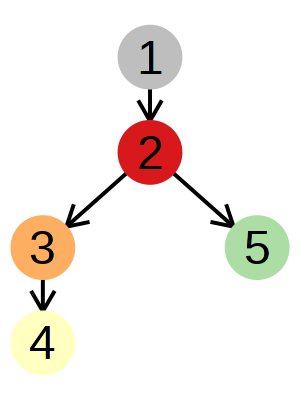

In [30]:
options(repr.plot.width = 1.5, repr.plot.height = 2, repr.plot.res = 200)
R.utils::sourceDirectory('~/Numbat/R')

plot_mut_history(res$G_m, horizontal = F, label = F)

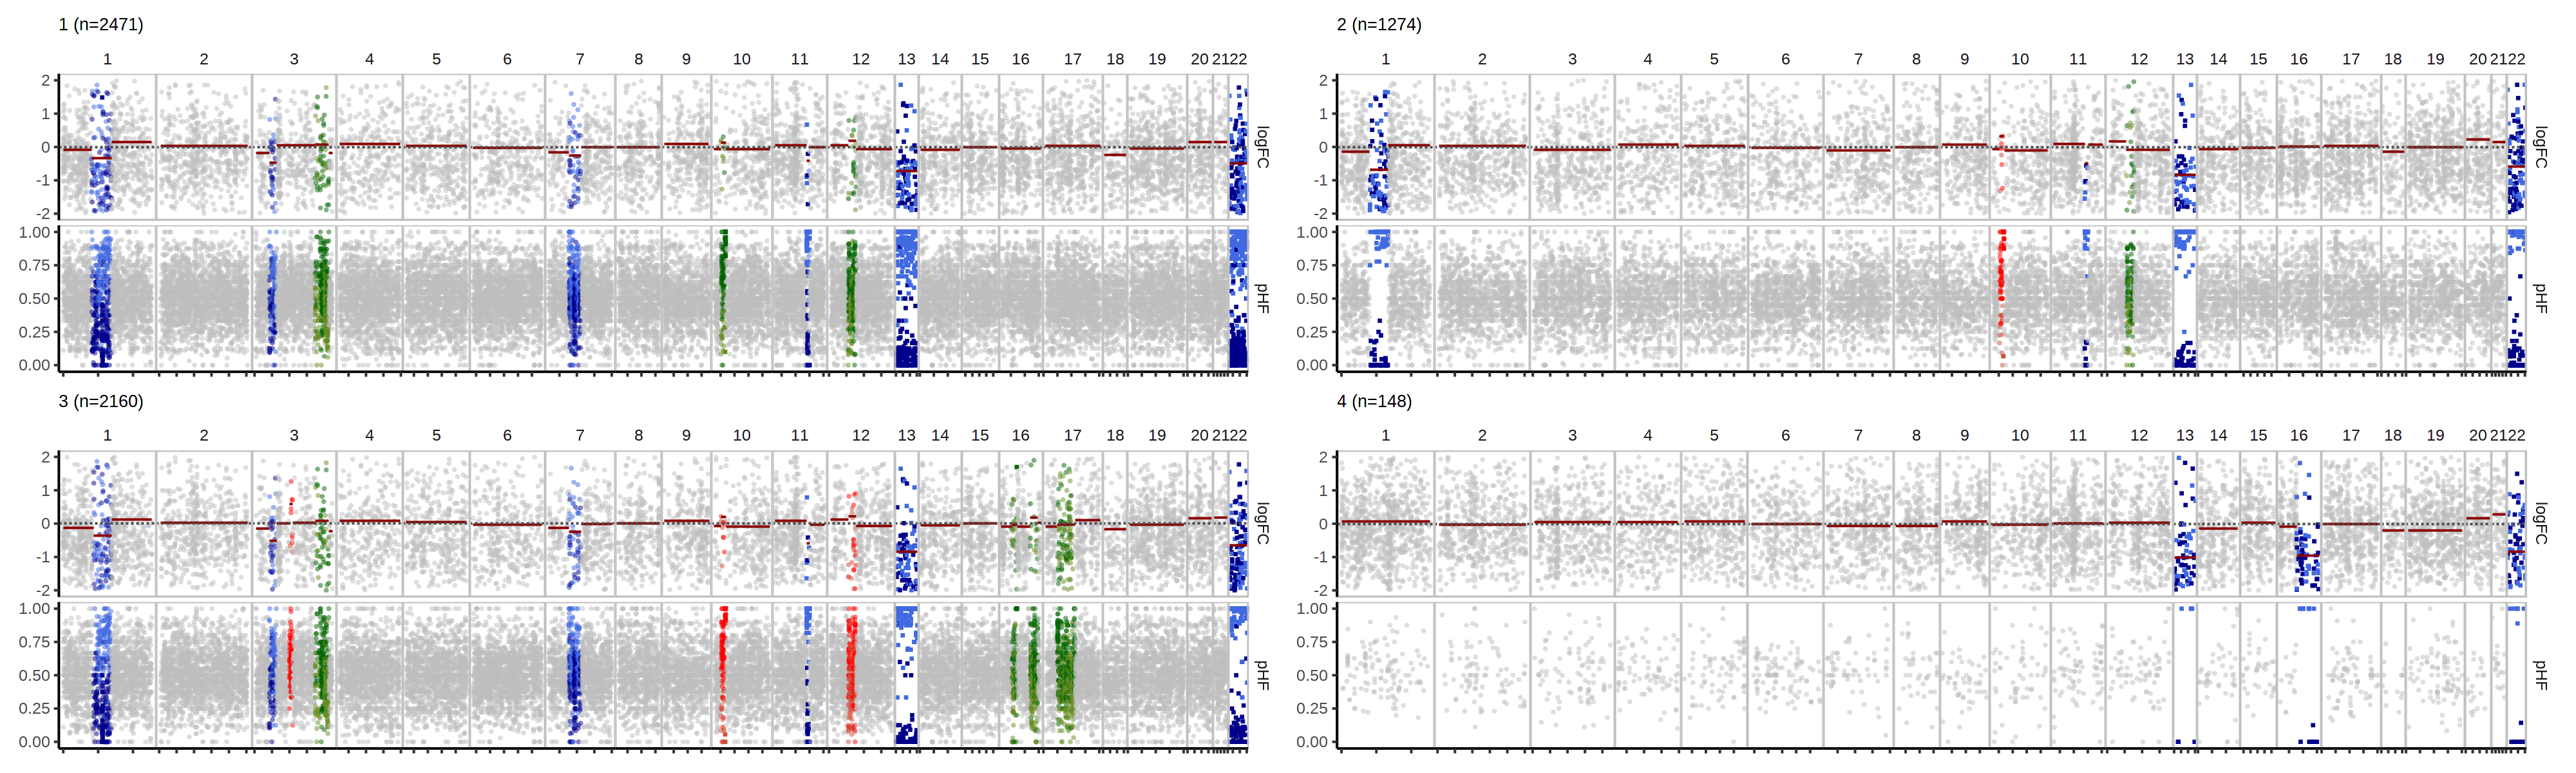

In [19]:
options(repr.plot.width = 20, repr.plot.height = 6, repr.plot.res = 200)
R.utils::sourceDirectory('~/Numbat/R')

plot_bulks(nb$bulk_subtrees, ncol = 2)

In [23]:
nb$gtree = annot_superclones(nb$gtree, nb$geno)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


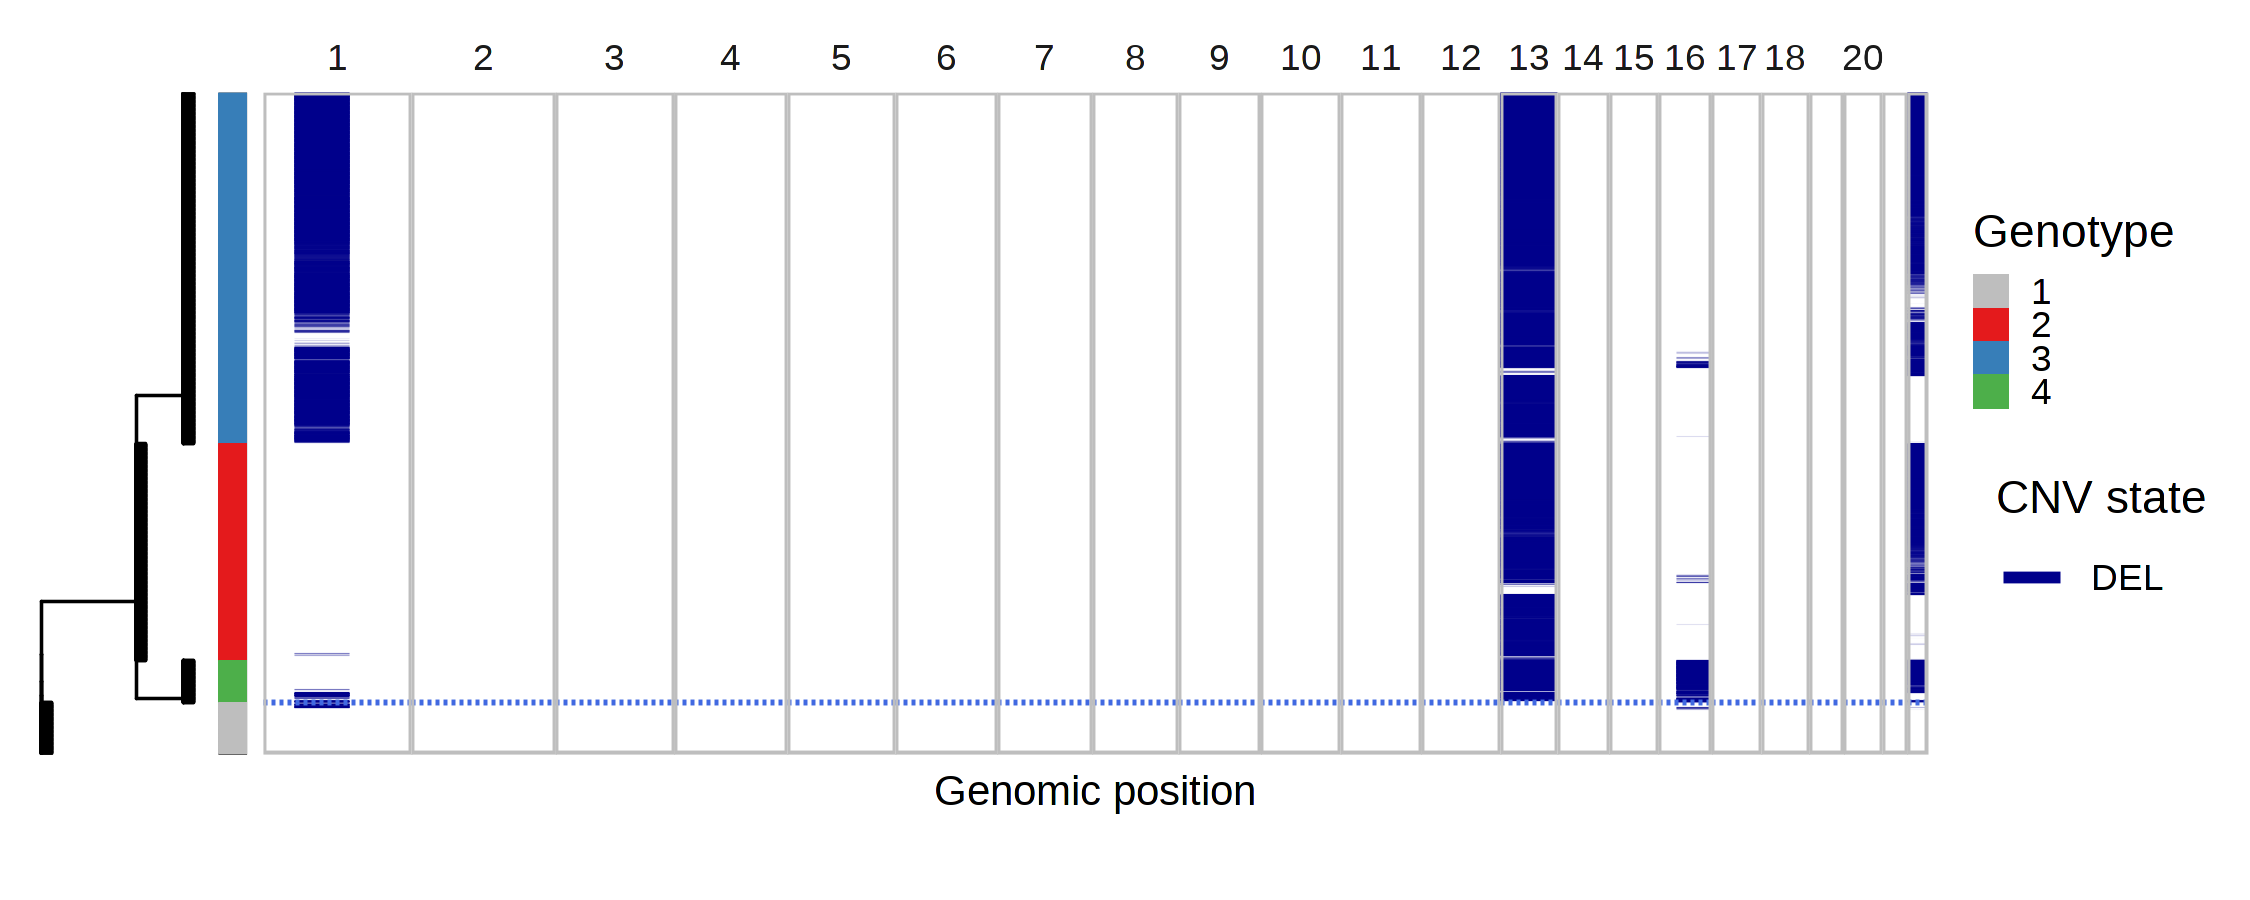

In [25]:
options(repr.plot.width = 7.5, repr.plot.height = 3, repr.plot.res = 300)

plot_phylo_heatmap(
    nb$gtree,
    nb$joint_post %>%
        left_join(
            nb$segs_consensus %>% 
                select(any_of(c('seg' = 'seg_cons', 'seg_start', 'seg_end', 'n_states', 'cnv_states'))),
            by = 'seg'
        ) %>% 
        filter(seg %in% colnames(nb$geno)),
    nb$segs_consensus,
    tip_length = 0.2,
    p_min = 0.5,
    geno_bar = T,
    superclone = T,
    branch_width = 0.3,
    tree_height = 1.5,
    annot_title = 'Sample',
    pal_clone = c('gray', RColorBrewer::brewer.pal(n = 8, 'Set1'))
)

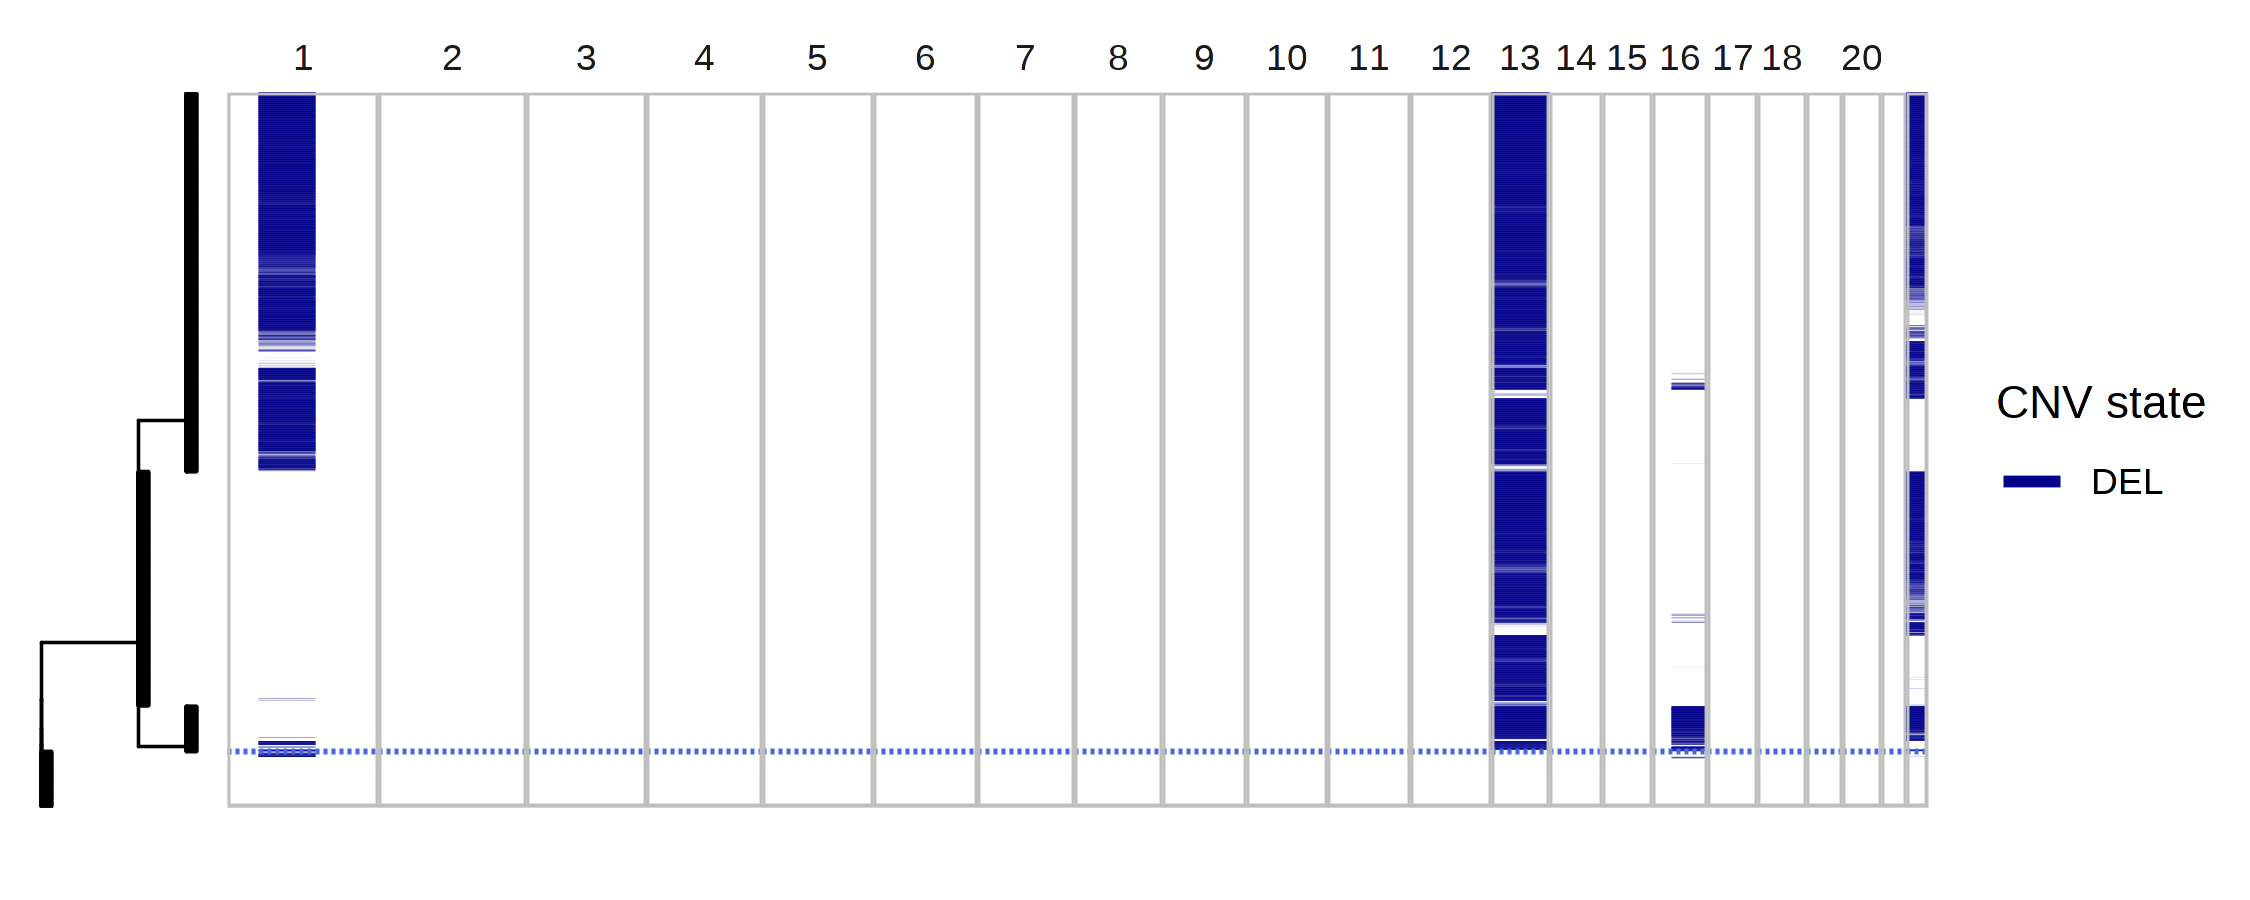

In [319]:
options(repr.plot.width = 7.5, repr.plot.height = 3, repr.plot.res = 300)
R.utils::sourceDirectory('~/Numbat/R')

p = plot_sc_joint(
    res$gtree %>% activate(nodes) %>%
        mutate(clone = as.integer(as.factor(GT))) %>%
        mutate(clone = ifelse(clone == 1, 'Normal', paste0('g', clone-1))) %>%
        mutate(clone = factor(clone, c('Normal', 'g1', 'g2', 'g3'))),
    res$joint_post %>% filter(seg %in% colnames(res$geno)),
    res$segs_consensus,
#     cell_dict = cell_annot[samples] %>% bind_rows %>%
#         mutate(sample_id = str_remove(sample_id,'27522_')) %>%
#         mutate(sample_id = str_replace(sample_id, '_', ' ')) %>%
#         mutate(sample_id = factor(sample_id, c('Primary', 'Remission', 'Relapse 1', 'Relapse 2'))) %>%
#         {setNames(.$sample_id, .$cell)},
    tip_length = 0.2,
    p_min = 0.5,
    size = 0.05,
    clone_bar = F,
    branch_width = 0.3,
    tree_height = 1.5,
    annot_title = 'Sample',
    pal_clone = c('gray', RColorBrewer::brewer.pal(n = 8, 'Set1'))
) +
theme(axis.title.x = element_blank()) &
theme(plot.background = element_rect(fill = "transparent", color = NA))

ggsave("~/figures/27522_phylogeny.png", p, bg = "transparent", width = 8, height = 3.5, dpi = 300)

p

Warning message:
“Removed 25157 rows containing missing values (geom_point).”
Warning message:
“Removed 28864 rows containing missing values (geom_point).”
Warning message:
“Removed 8813 rows containing missing values (geom_point).”


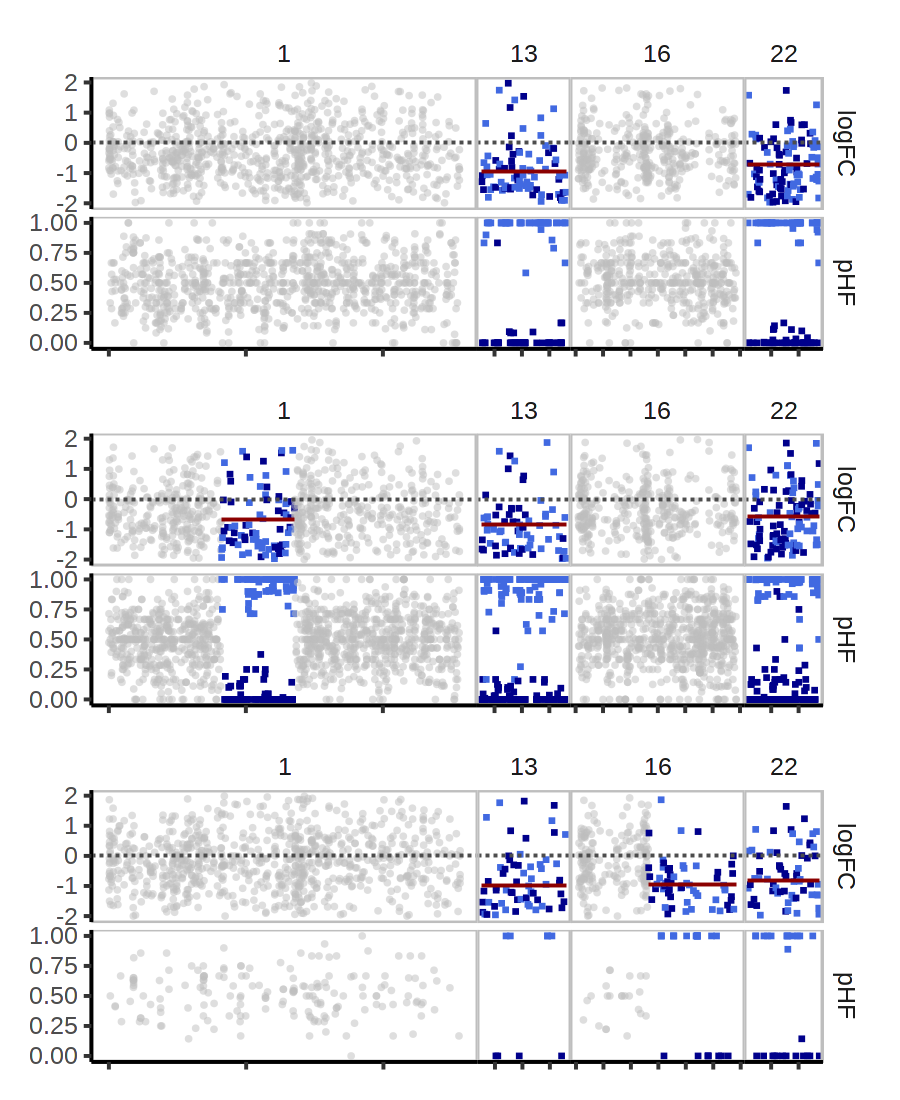

In [2031]:
options(repr.plot.width = 4.5, repr.plot.height = 5.5, repr.plot.res = 200)
R.utils::sourceDirectory('~/Numbat/R')

res$bulk_clones %>%
filter(sample %in% c(2,3,4)) %>%
filter(CHROM %in% c(1,13,16,22)) %>%
plot_bulks(ncol = 1, min_depth = 6, legend = F, phi_mle = TRUE, title = F)

In [520]:
# options(repr.plot.width = 14, repr.plot.height = 8, repr.plot.res = 200)
# R.utils::sourceDirectory('~/Numbat/R')

# res$bulk_clones %>% 
# plot_bulks(ncol = 2)

In [521]:
# options(repr.plot.width = 14, repr.plot.height = 8, repr.plot.res = 200)
# R.utils::sourceDirectory('~/Numbat/R')

# res[[sample]]$bulk_clones %>% 
# mutate(state_post = ifelse(CHROM %in% c(1, 13, 22, 16), state_post, 'neu')) %>%
# mutate(state_post = ifelse(CHROM %in% c(16) & cnv_state == 'amp_1', 'neu', state_post)) %>%
# plot_bulks(ncol = 1)

### CopyKat

In [22]:
patient = '27522'

In [55]:
CNA.test = fread(glue('/home/tenggao/copykat_results/{patient}/27522_copykat_CNA_results.txt'))
pred.test = fread(glue('/home/tenggao/copykat_results/{patient}/{patient}_copykat_prediction.txt'))

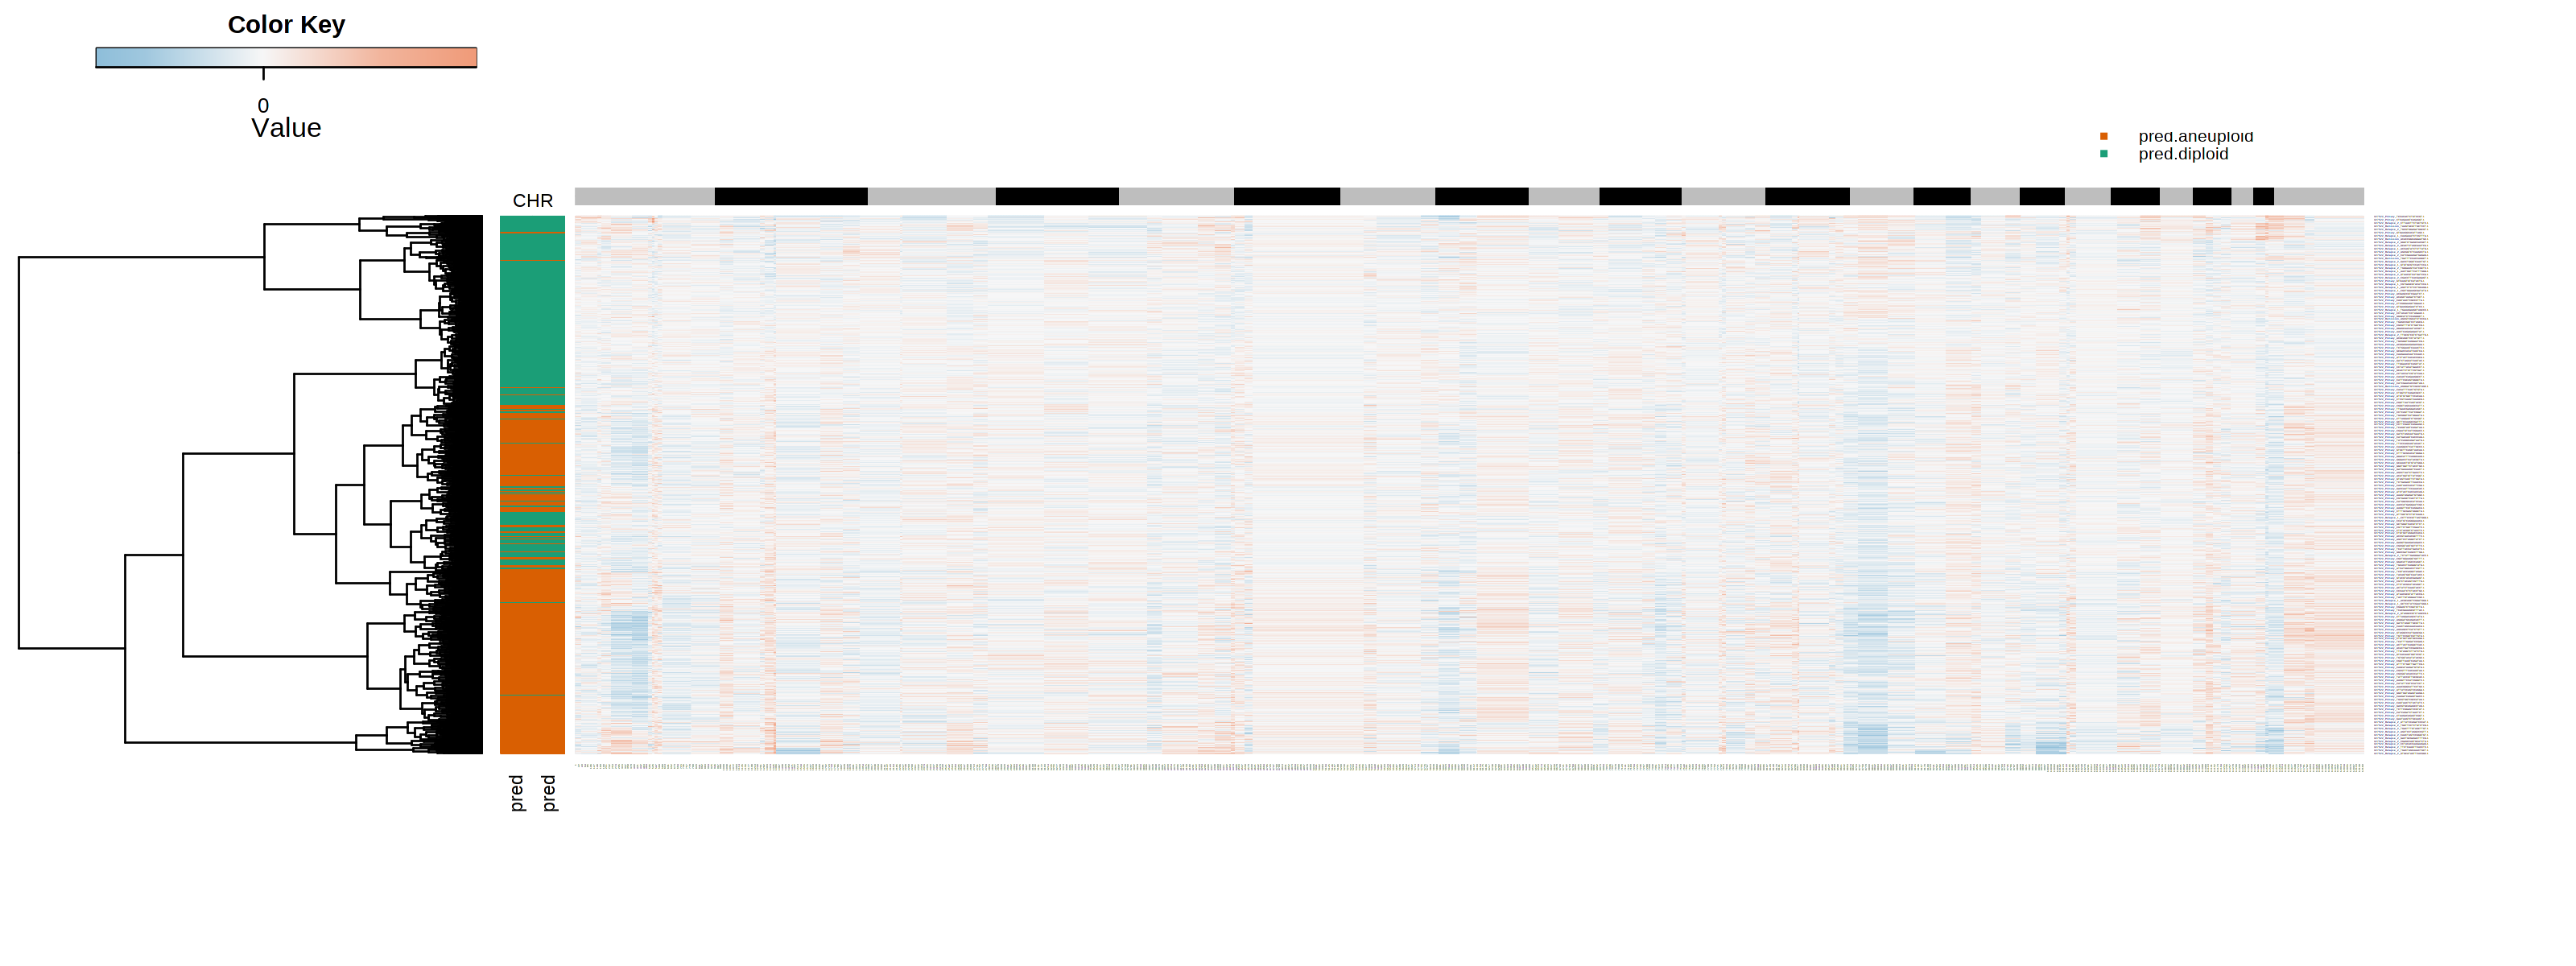

In [58]:
options(repr.plot.width = 16, repr.plot.height = 6, repr.plot.res = 200)

my_palette <- colorRampPalette(rev(RColorBrewer::brewer.pal(n = 3, name = "RdBu")))(n = 999)

chr <- as.numeric(CNA.test$chrom) %% 2+1
rbPal1 <- colorRampPalette(c('black','grey'))
CHR <- rbPal1(2)[as.numeric(chr)]
chr1 <- cbind(CHR,CHR)

rbPal5 <- colorRampPalette(RColorBrewer::brewer.pal(n = 8, name = "Dark2")[2:1])
com.preN <- pred.test$copykat.pred
pred <- rbPal5(2)[as.numeric(factor(com.preN))]

cells <- rbind(pred,pred)
col_breaks = c(seq(-1,-0.4,length=50),seq(-0.4,-0.2,length=150),seq(-0.2,0.2,length=600),seq(0.2,0.4,length=150),seq(0.4, 1,length=50))

copykat::heatmap.3(t(CNA.test[,4:ncol(CNA.test)]),dendrogram="r",
        distfun = function(x) parallelDist::parDist(x,threads =4, method = "euclidean"), hclustfun = function(x) hclust(x, method="ward.D2"),
        ColSideColors=chr1,RowSideColors=cells,Colv=NA, Rowv=TRUE,
        notecol="black",col=my_palette,breaks=col_breaks, key=TRUE,
        keysize=1, density.info="none", trace="none",
        cexRow=0.1,cexCol=0.1,cex.main=1,cex.lab=0.1,
        symm=F,symkey=F,symbreaks=T,cex=1, cex.main=4, margins=c(10,10))

legend("topright", paste("pred.",names(table(com.preN)),sep=""), pch=15,col=RColorBrewer::brewer.pal(n = 8, name = "Dark2")[2:1], cex=0.6, bty="n")

### InferCNV

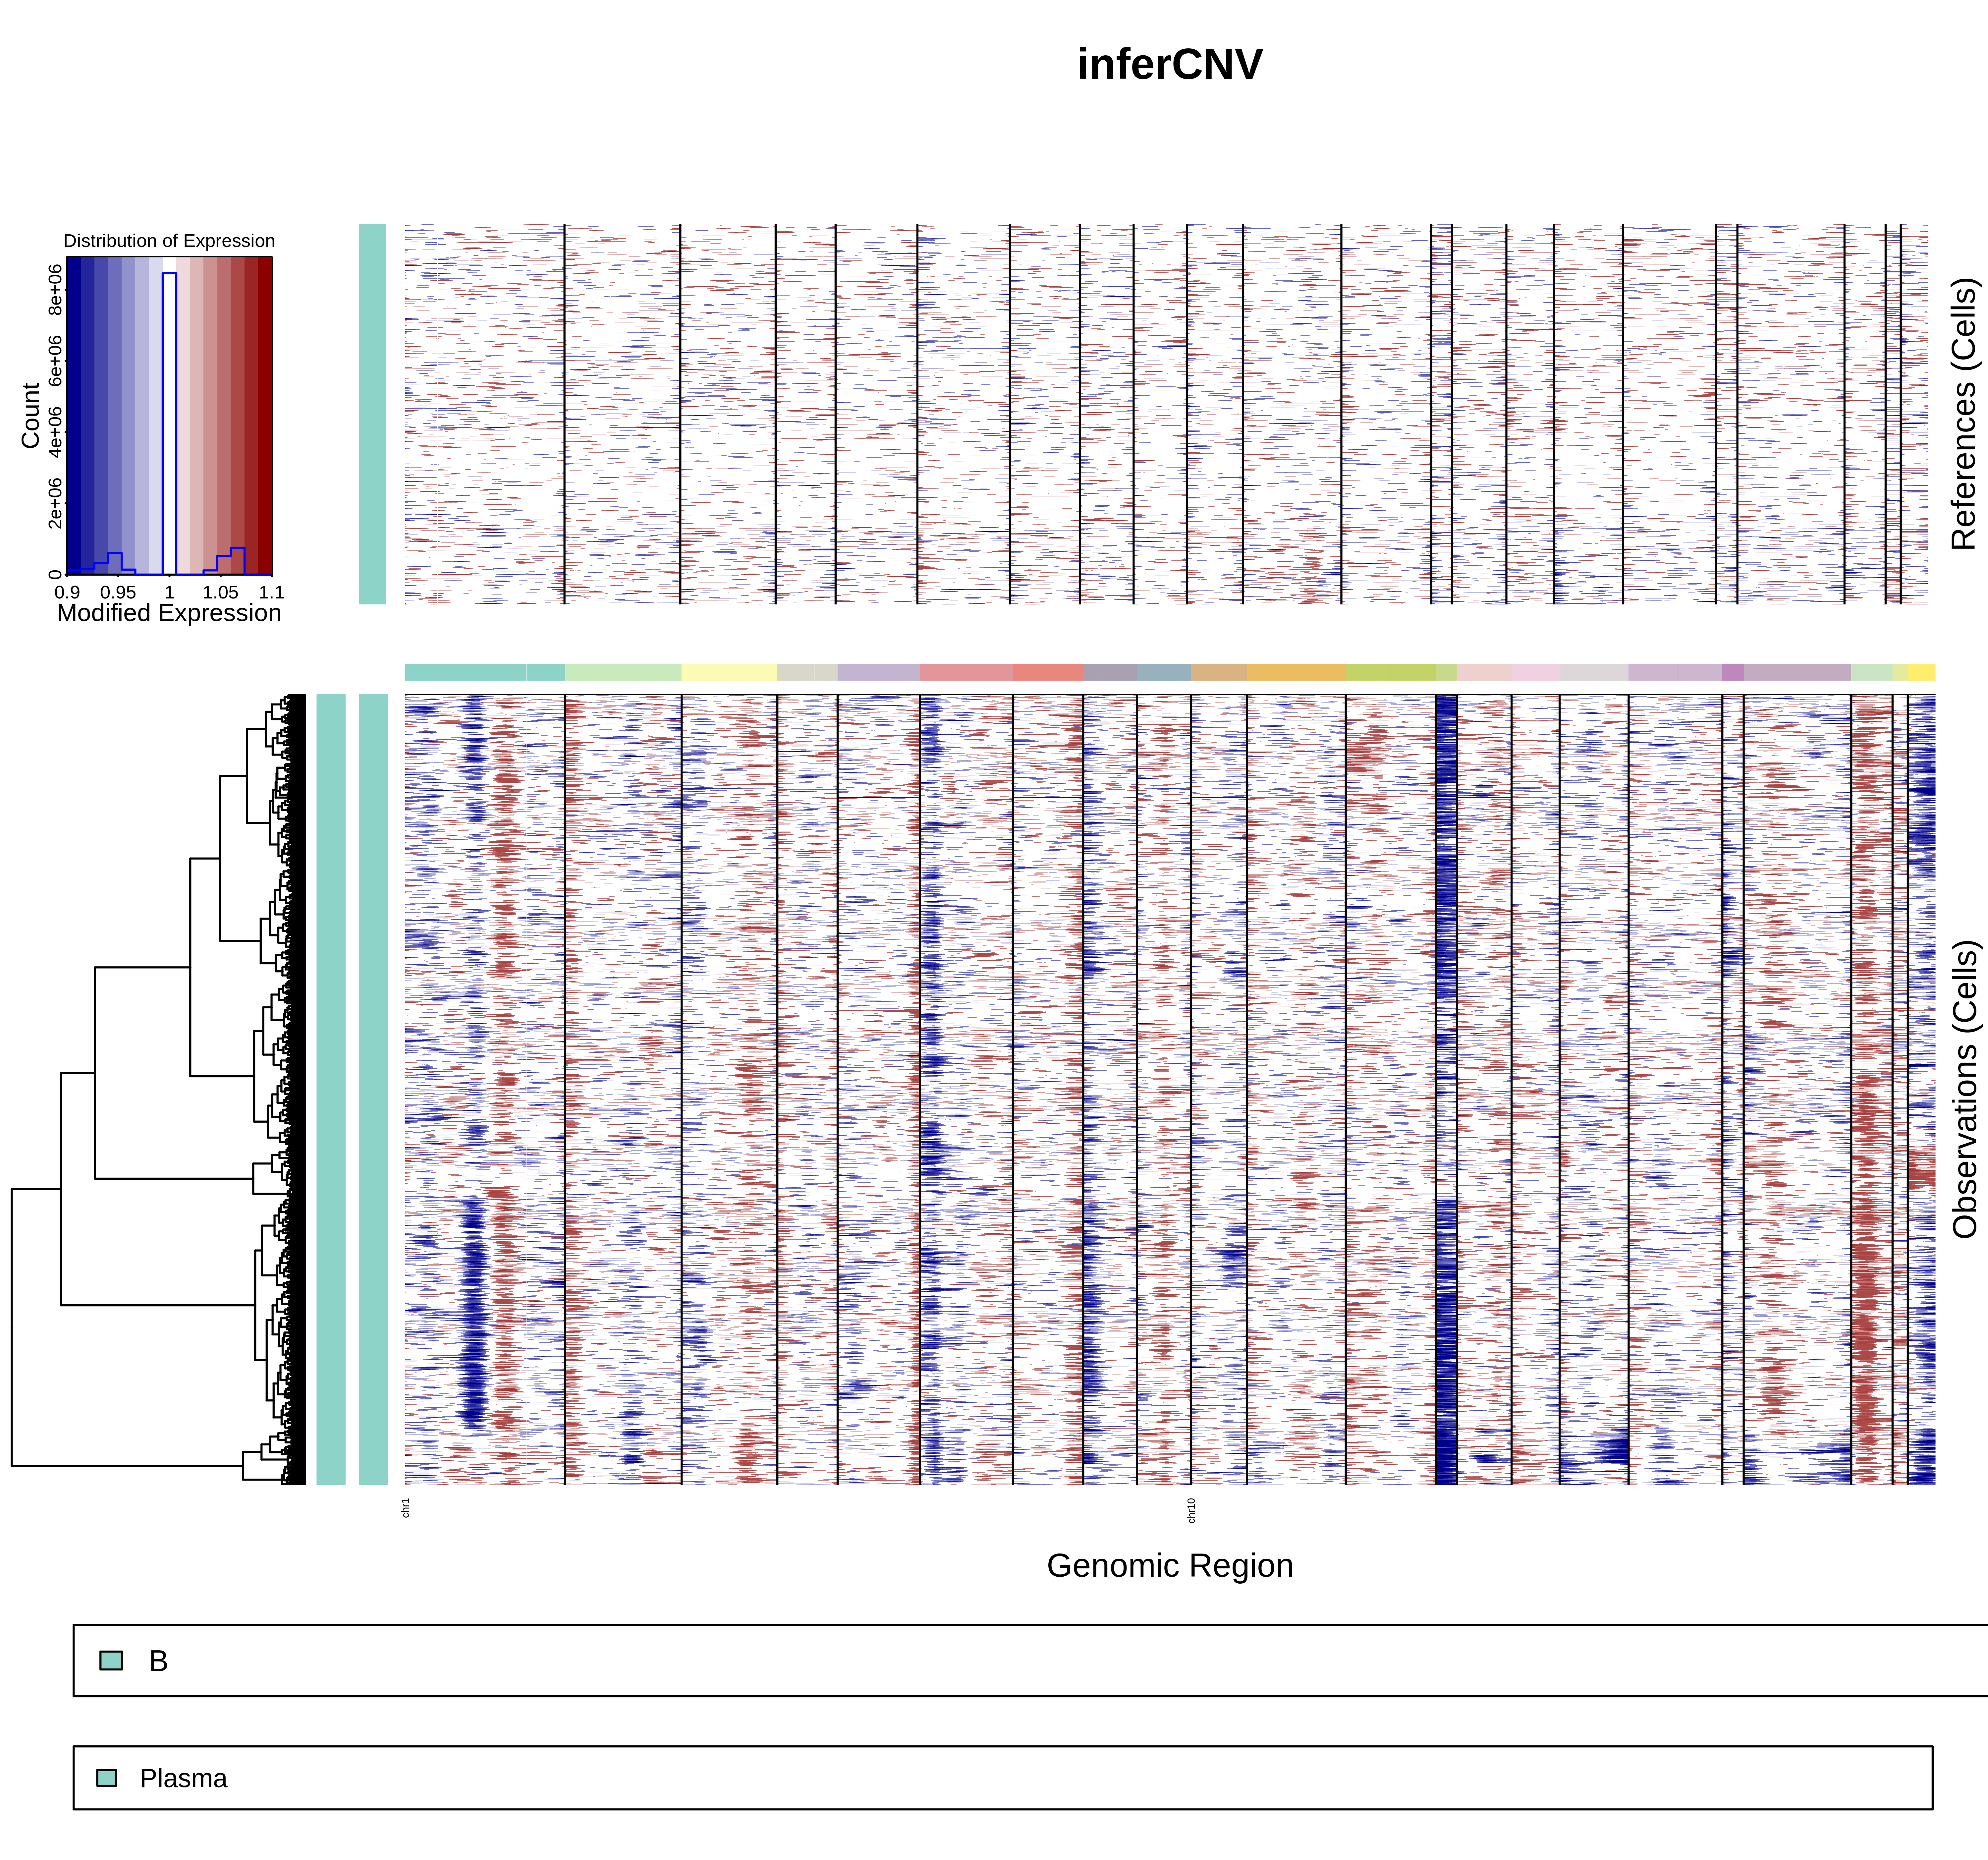

In [1171]:
display_png(file = glue('/home/tenggao/inferCNV/{patient}/infercnv.png'), width = 800)

### DE

### GSEA

In [41]:
library(liger)

h_gene_sets = msigdbr::msigdbr(species = "human", category = "H") %>%
    split(.$gs_name) %>%
    lapply(function(x) {unique(x$gene_symbol)})

names(h_gene_sets) = str_remove(names(h_gene_sets), 'HALLMARK_')

#### Plotting

In [214]:
gsea = function (values, geneset, q.val, ypos = 'top', power = 1, rank = FALSE, weight = rep(1, 
    length(values)), n.rand = 10000, plot = TRUE, main = "", 
    return.details = FALSE, quantile.threshold = min(100/n.rand, 
        0.1), random.seed = 1, mc.cores = 1) 
{
    set <- names(values) %in% geneset
    vo <- order(values, decreasing = TRUE)
    values <- values[vo]
    set <- set[vo]
    weight <- weight[vo]
    if (rank) {
        es <- weight
    }
    else {
        es <- (abs(values)^power) * weight
    }
    eso <- es
    es[set] <- es[set]/sum(es[set])
    es[!set] <- -1 * es[!set]/sum(es[!set])
    es <- es * length(values)
    sv <- cumsum(es)
    sv.p <- max(0, max(sv))
    sv.n <- min(0, min(sv))
    p.x.p <- which.max(sv)
    p.x.n <- which.min(sv)
    if (mc.cores > 1) {
        rvll <- parallel::mclapply(1:mc.cores, function(i) {
            set.seed(random.seed + i)
            gseaRandCore(set, eso, nsamples = ceiling(n.rand/mc.cores))
        }, mc.preschedule = TRUE, mc.cores = mc.cores)
        rvl <- list(p = unlist(lapply(rvll, function(x) x$p)), 
            n = unlist(lapply(rvll, function(x) x$n)))
    }
    else {
        set.seed(random.seed)
        rvl <- liger:::gseaRandCore(set, eso, nsamples = n.rand)
    }
    p.v.p <- (sum(rvl$p >= sv.p) + 1)/(length(rvl$p + 1))
    p.v.n <- (sum(rvl$n <= sv.n) + 1)/(length(rvl$n + 1))
    p.x <- ifelse(p.v.p < p.v.n, p.x.p, p.x.n)
    p.v <- ifelse(p.v.p < p.v.n, p.v.p, p.v.n)
    if (p.v.p < p.v.n) {
        q.thr <- stats::quantile(rvl$p, p = (1 - quantile.threshold))
    }
    else {
        q.thr <- stats::quantile(rvl$n, p = quantile.threshold)
    }
    if (plot) {
        l <- graphics::layout(matrix(c(1, 2, 3), 3, 1, byrow = T), 
            c(1, 1, 1), c(1.4, 0.3, 0.9), FALSE)
        graphics::par(mar = c(0.1, 3.5, 1.5, 0.5), mgp = c(2, 
            0.65, 0), cex = 0.9)
        plot(c(1:length(sv)), sv, type = "l", ylab = "Score", 
            xaxt = "n", xlab = "", main = main, xaxs = "i", xlim = c(1, 
                length(sv)), col = "darkblue", cex.main=1.5)
        graphics::segments(p.x, 0, p.x, sv[p.x], col = 2, lty = 2)
        graphics::segments(0, sv[p.x], p.x, sv[p.x], col = 2, 
            lty = 2)
        qv.p <- stats::quantile(rvl$p, p = 1 - 10^(-1 * seq(1, 
            round(log10(length(rvl$p))))))
        qv.n <- -1 * stats::quantile(-1 * rvl$n, p = 1 - 10^(-1 * 
            seq(1, round(log10(length(rvl$n))))))
        graphics::abline(h = c(qv.p, qv.n), lty = 3, col = 8)
        graphics::abline(h = 0, lty = 2, col = 8)
        xpos <- "right"
        if (p.x > round(length(sv)/2)) {
            xpos <- "left"
        }
        graphics::legend(x = ifelse(sv[round(length(sv)/2)] > 
            sv[p.x], paste(ypos, xpos, sep = ""), paste(ypos, 
            xpos, sep = "")), bty = "n", legend = paste("q =", 
            format(q.val, digits = 3)), inset=c(0.1,0))
        graphics::par(mar = c(0.1, 3.5, 0.1, 0.5))
        mset <- set
        mset[!set] <- NA
        plot(mset, xaxt = "n", ylim = c(0, 1), xlab = "", ylab = "", 
            xaxs = "i", yaxt = "n", type = "h", col = "blue")
        graphics::abline(v = p.x, col = 2, lty = 2)
        graphics::box()
        graphics::par(mar = c(0.5, 3.5, 0.1, 0.5))
        plot(values, ylab = "logFC", xaxs = "i", type = "h", 
            xaxt = "n", col = "darkblue")
#         graphics::legend(x = "topright", bty = "n", legend = paste("edge value = ", 
#             format(values[p.x], digits = 2)))
        graphics::abline(v = p.x, col = 2, lty = 2)
        graphics::box()
    }
    if (return.details) {
        rv <- c(p.val = p.v, edge.score = as.numeric(sv[p.x]), 
            edge.value = as.numeric(values[p.x]), scaled.score = as.numeric(sv[p.x]/q.thr))
        return(rv)
    }
    else {
        return(p.v)
    }
}

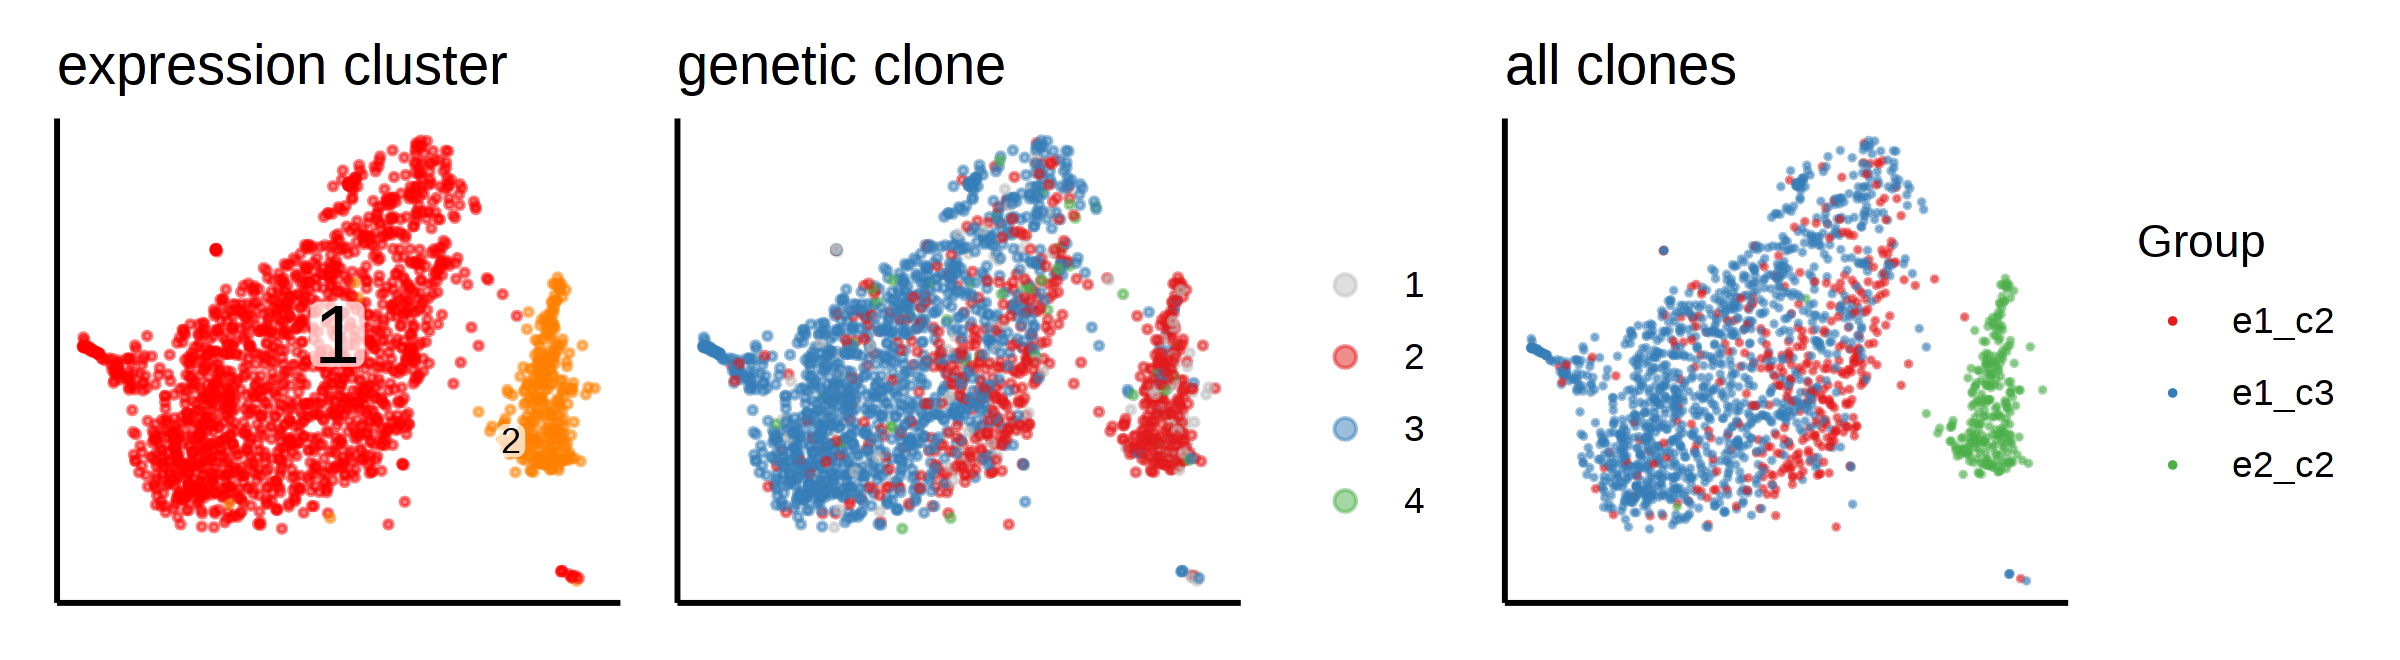

In [377]:
options(repr.plot.width = 8, repr.plot.height = 2.2, repr.plot.res = 300)

con_sample = con$samples[['27522_Primary']]

con_clusters = con_sample$clusters$PCA$multilevel
con_clusters = con_clusters[names(con_clusters) %in% res$clone_post$cell]
con_clusters[con_clusters %in% c(2,3,8)] = 1
con_clusters[con_clusters %in% c(12)] = 2
con_clusters = con_clusters[con_clusters %in% c(1,2)]

clone_annot = res$clone_post %>%
#     filter(p_opt > 0.5) %>%
    mutate(cluster = con_clusters[cell]) %>%
    filter(!is.na(cluster))

group_annot = clone_annot %>% 
    mutate(group = case_when(
        cluster == 2 & clone_opt == 2 ~ 'e2_c2',
        cluster == 1 & clone_opt == 2 ~ 'e1_c2',
        cluster == 1 & clone_opt == 3 ~ 'e1_c3'
    )) %>%
    filter(!is.na(group))

p1 = con_sample$plotEmbedding(
    alpha=0.5,
    size=0.5, 
    groups = clone_annot %>% {setNames(.$cluster, .$cell)},
    show.legend = F,
    plot.na = F,
    plot.theme = theme_classic(),
    title = 'expression cluster'
) +
guides(color = guide_legend(title = 'cluster'))

p2 = con_sample$plotEmbedding(
    alpha=0.5,
    size=0.5, 
    groups = clone_annot %>% {setNames(.$clone_opt, .$cell)},
    plot.na = F,
    show.legend = T,
    mark.groups = F,
    palette = c('gray', pal[1:3]),
    plot.theme = theme_classic(),
    title = 'genetic clone'
) +
guides(color = guide_legend(title = '', override.aes = list(size = 2)))

p3 = con_sample$plotEmbedding(
    alpha=0.5,
    size=0.2, 
    groups = group_annot %>% {setNames(.$group, .$cell)},
    plot.na = F,
    show.legend = T,
    mark.groups = F,
    palette = pal[1:3],
    plot.theme = theme_classic(),
    title = 'all clones'
) 

p1 | p2 | p3

#### Cluster 1 vs 2

In [378]:
# cluster1 vs 2
sample = '27522_Primary'

de_annot = clone_annot %>% filter(cluster %in% c(1,2))

con$samples[[sample]]$getDifferentialGenes(
    groups = de_annot %>% {setNames(.$cluster, .$cell)},
    append.auc = T
)

genes = rownames(count_mat[[sample]])[rowSums(count_mat[[sample]][,de_annot$cell] > 1) > 5]

fold_changes = make_psbulk(
        count_mat[[sample]][genes,],
        de_annot %>% mutate(cell_type = factor(cluster, c(1,2)))
    )$exp_mat %>%
    data.frame() %>%
    setNames(c('lambda_x', 'lambda_y')) %>%
    tibble::rownames_to_column('gene') %>%
    mutate(logFC = log2(lambda_x/lambda_y)) %>%
    filter(!is.na(logFC))

Warning message in con$samples[[sample]]$getDifferentialGenes(groups = de_annot %>% :
“cluster vector doesn't specify groups for all of the cells, dropping missing cells from comparison”
1716322



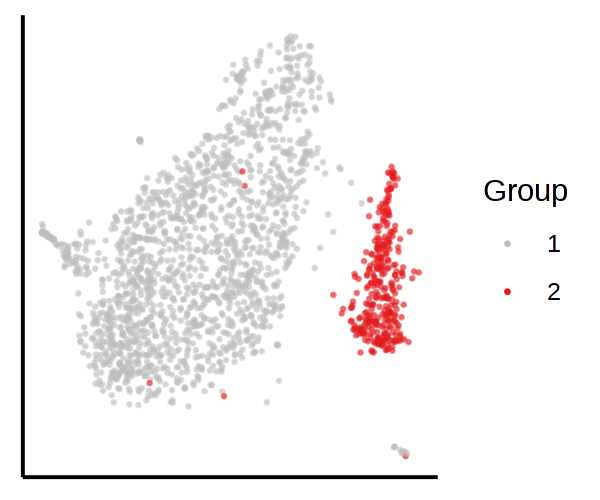

In [347]:
options(repr.plot.width = 3, repr.plot.height = 2.5, repr.plot.res = 200)

con_sample$plotEmbedding(
    alpha=0.5,
    size=0.2, 
    groups = de_annot %>% {setNames(droplevels(.$cluster), .$cell)},
    plot.na = F,
    show.legend = T,
    mark.groups = F,
    palette = c('gray', pal[1:3]),
    plot.theme = theme_classic(),
) 

Warning message:
“ggrepel: 349 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


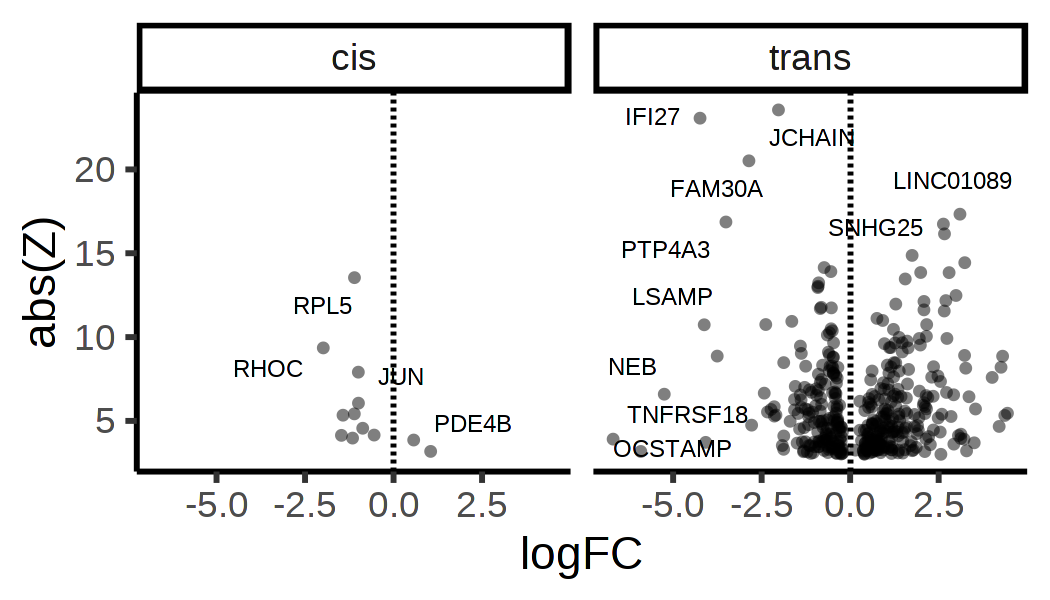

In [380]:
options(repr.plot.width = 3.5, repr.plot.height = 2, repr.plot.res = 300)

seg_start = 52085411
seg_end = 121518467

DE = con$samples[[sample]]$diffgenes$counts$customClustering[[1]] %>%
    tibble::rownames_to_column('gene') %>%
    inner_join(gtf_transcript, by = 'gene') %>%
    left_join(fold_changes, by = 'gene') %>%
    mutate(loc = ifelse(CHROM == 1 & gene_start < seg_end & gene_end > seg_start, 'cis', 'trans'))

ggplot(
    DE,
    aes(x = logFC, y = abs(Z))
) +
geom_point(size = 1, alpha = 0.5, pch = 16) +
theme_classic() +
scale_color_manual(values = c('gray', 'red')) +
facet_wrap(~loc) +
ggrepel::geom_text_repel(aes(label = gene), size = 2) +
geom_vline(xintercept = 0, linetype = 'dashed')

In [326]:
count_mat_combined = lapply(samples, function(sample) {con$samples[[sample]]$counts}) %>% Reduce('rbind', .) %>% as.matrix

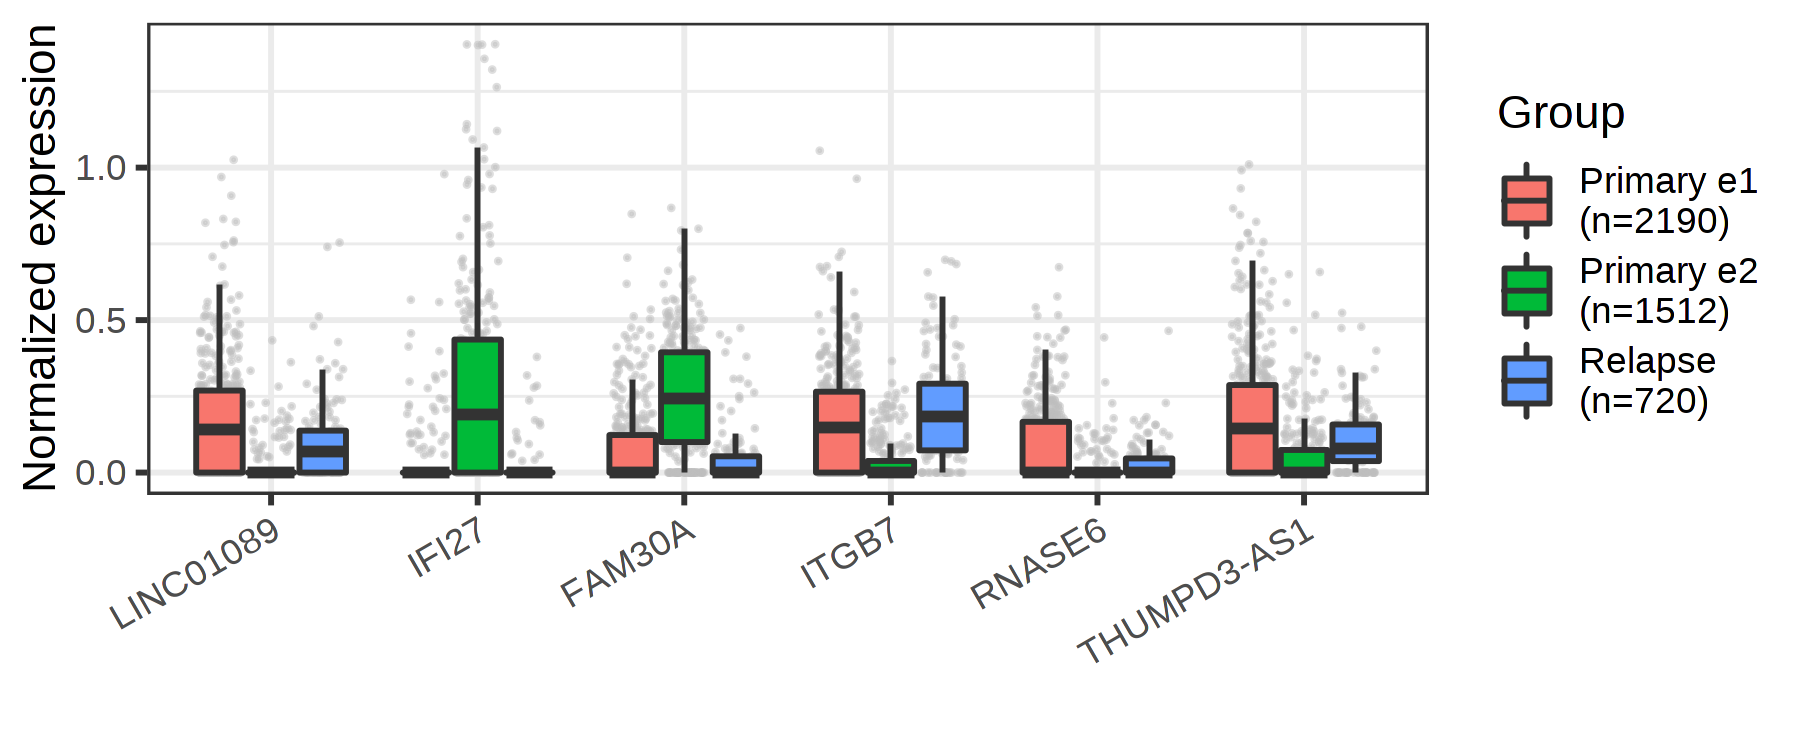

In [382]:
options(repr.plot.width = 6, repr.plot.height = 2.5, repr.plot.res = 300)

cells = res$clone_post %>% filter(clone_opt == 2) %>% pull(cell)
markers = DE %>% filter(loc == 'trans') %>% arrange(-AUC) %>% head %>% pull(gene)
D = count_mat_combined[cells, markers] %>%
    reshape2::melt() %>%
    setNames(c('cell', 'gene', 'exp')) %>%
    left_join(bind_rows(cell_annot[samples]), by = 'cell') %>%
    mutate(
        cluster = ifelse(sample_id == '27522_Primary', con_clusters[as.character(cell)], sample_id)
    ) %>%
    filter(cell_type == 'Plasma') %>%
    filter(cluster %in% c(1,2, c('27522_Relapse_2', '27522_Relapse_1'))) %>%
    mutate(cluster = c('1' = 'Primary e1', '2' = 'Primary e2', '27522_Relapse_2' = 'Relapse', '27522_Relapse_1' = 'Relapse')[cluster]) %>%
    group_by(cluster) %>%
    mutate(n_cluster = n()) %>%
    mutate(cluster = glue('{cluster}\n(n={n_cluster})')) %>%
    ungroup()

ggplot(
    D,
    aes(x = gene, fill = cluster, y = exp)
) +
geom_jitter(aes(group = cluster), size = 0.1, alpha = 0.5, color = 'gray', position = position_jitterdodge(jitter.width = 0.2)) +
geom_boxplot(outlier.size = 0, outlier.alpha = 0) +
theme_bw() +
theme(
    axis.text.x = element_text(angle = 30, hjust = 1)
) +
xlab('') +
ylab('Normalized expression') +
guides(fill=guide_legend(
    keywidth=0.2,
    keyheight=0.3,
    default.unit="inch",
    title = 'Group')
)

In [1024]:
gsea_out = bulk.gsea(
    values = fold_changes %>% filter(!is.infinite(logFC)) %>% {setNames(.$logFC, .$gene)},
    set.list = h_gene_sets,
    mc.cores = 10
)

In [49]:
gsea_out %>%
tibble::rownames_to_column('gene.set') %>%
filter(q.val < 0.05) %>%
arrange(q.val, sscore)

ERROR: Error in tibble::rownames_to_column(., "gene.set"): object 'gsea_out' not found


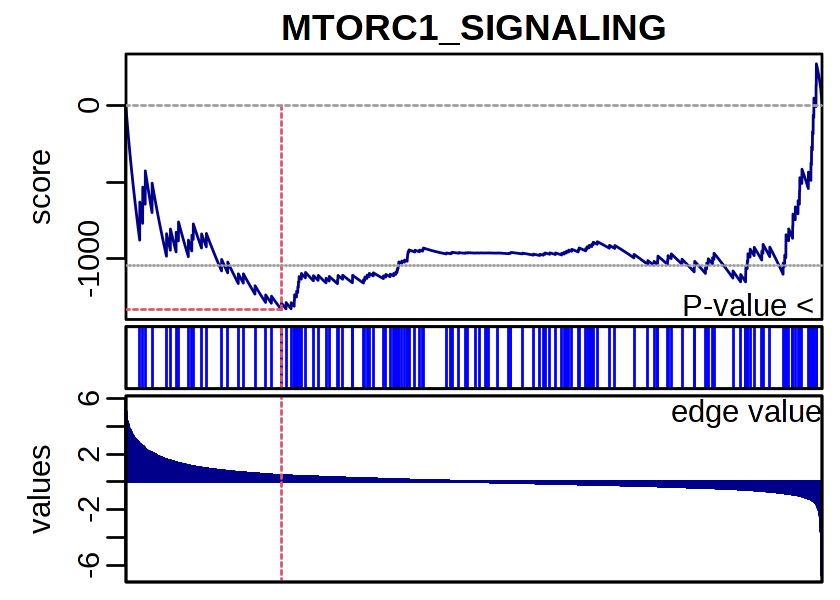

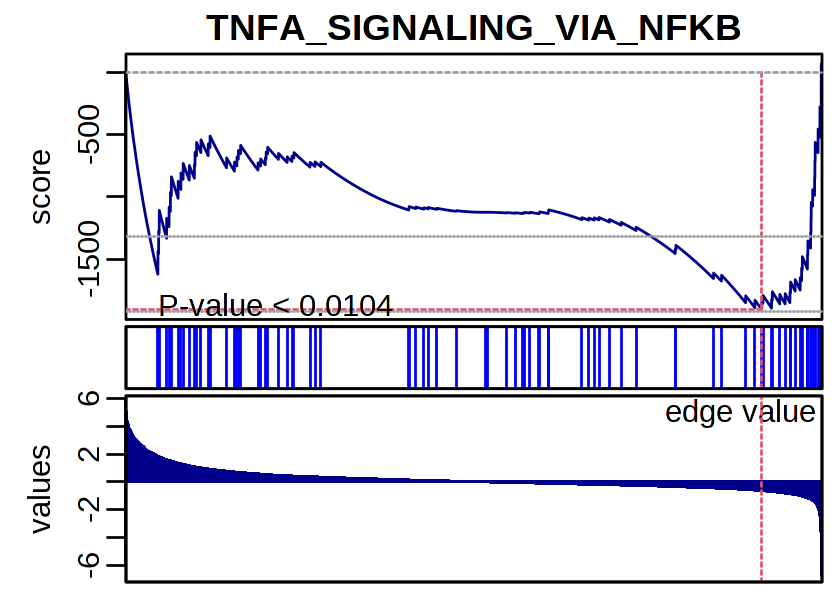

In [1028]:
options(repr.plot.width = 4.2, repr.plot.height = 3, repr.plot.res = 200)

for (gs in c('MTORC1_SIGNALING', 'TNFA_SIGNALING_VIA_NFKB')) {

    gsea(
        fold_changes %>% filter(!is.infinite(logFC)) %>% {setNames(.$logFC, .$gene)},
        h_gene_sets[[gs]],
        main = str_remove(gs, 'HALLMARK_')
    )
    
}

#### **Restrict to clone 2**

In [364]:
# cluster1 vs 2
sample = '27522_Primary'

de_annot = group_annot %>% filter(group %in% c('e2_c2', 'e1_c2'))

con$samples[[sample]]$getDifferentialGenes(
    groups = de_annot %>% {setNames(.$group, .$cell)}
)

fold_changes = make_psbulk(
        count_mat[[sample]],
        de_annot %>% mutate(cell_type = factor(group, c('e2_c2', 'e1_c2')))
    )$exp_mat %>%
    data.frame() %>%
    setNames(c('lambda_x', 'lambda_y')) %>%
    tibble::rownames_to_column('gene') %>%
    mutate(logFC = log2(lambda_x/lambda_y)) %>%
    filter(!is.na(logFC))

Warning message in con$samples[[sample]]$getDifferentialGenes(groups = de_annot %>% :
“cluster vector doesn't specify groups for all of the cells, dropping missing cells from comparison”
252365



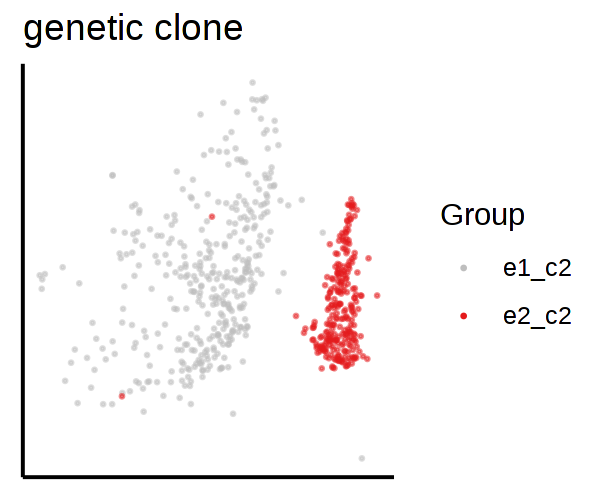

In [365]:
options(repr.plot.width = 3, repr.plot.height = 2.5, repr.plot.res = 200)

con_sample$plotEmbedding(
    alpha=0.5,
    size=0.2, 
    groups = de_annot %>% {setNames(factor(.$group), .$cell)},
    plot.na = F,
    show.legend = T,
    mark.groups = F,
    palette = c('gray', pal[1:3]),
    plot.theme = theme_classic(),
    title = 'genetic clone'
)

In [217]:
expressed_genes = rownames(count_mat[[sample]])[rowSums(count_mat[[sample]][,de_annot$cell] > 0) >= 5]

gsea_out = bulk.gsea(
    values = fold_changes %>% 
        filter(gene %in% expressed_genes) %>%
        filter(!is.infinite(logFC)) %>% 
        {setNames(.$logFC, .$gene)},
    set.list = h_gene_sets,
    mc.cores = 10
) %>%
tibble::rownames_to_column('gene.set') 

In [218]:
gsea_out %>%
filter(q.val < 0.05 & sscore * edge > 0) %>%
arrange(q.val, -sscore) 

gene.set                p.val      q.val        sscore   edge     
1 TNFA_SIGNALING_VIA_NFKB 0.00059994 0.0009333333 1.340163 0.5601620
2 CHOLESTEROL_HOMEOSTASIS 0.00069993 0.0013062500 1.270536 0.8361039
3 IL2_STAT5_SIGNALING     0.00969903 0.0188333333 1.006915 1.6426241

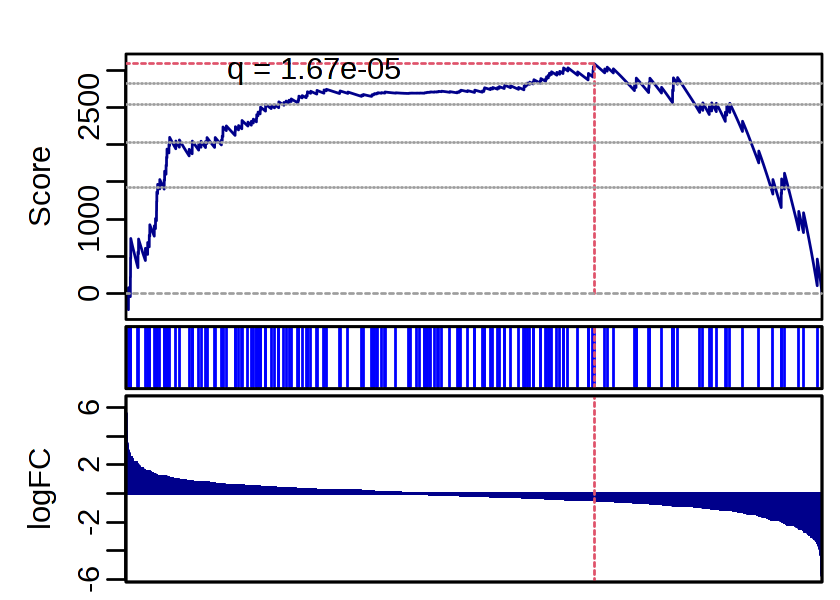

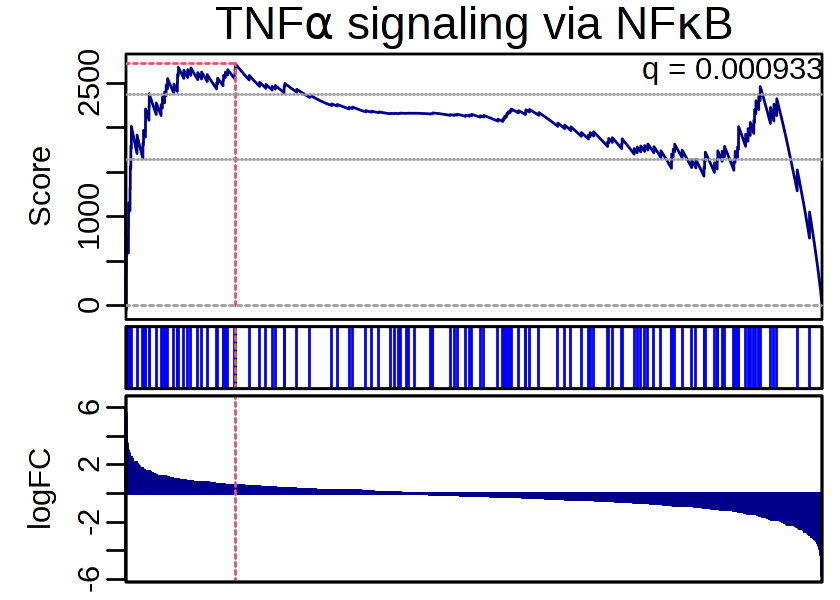

In [219]:
options(repr.plot.width = 4.2, repr.plot.height = 3, repr.plot.res = 200)
expressed_genes = rownames(count_mat[[sample]])[rowSums(count_mat[[sample]][,de_annot$cell] > 0) >= 5]

rename_dict = c('TNFA_SIGNALING_VIA_NFKB' = expression(paste("TNF", alpha, " signaling via NF", kappa, "B")))

for (gs in c('MTORC1_SIGNALING', 'TNFA_SIGNALING_VIA_NFKB')) {

    gsea(
        values = fold_changes %>% 
            filter(gene %in% expressed_genes) %>%
            filter(!is.infinite(logFC)) %>%
            {setNames(.$logFC, .$gene)},
        h_gene_sets[[gs]],
        q.val = gsea_out %>% filter(gene.set == gs) %>% pull(q.val),
        main = rename_dict[gs]
        
    )
    
}

#### **Within cluster clone 2 vs 3**

In [376]:
sample = '27522_Primary'

de_annot = group_annot %>% filter(group %in% c('e1_c2', 'e1_c3'))

con_sample$getDifferentialGenes(
    groups = de_annot %>% {setNames(.$clone_opt, .$cell)}
)

fold_changes = make_psbulk(
        count_mat[[sample]],
        de_annot %>% mutate(cell_type = factor(clone_opt, c(3,2)))
    )$exp_mat %>%
    data.frame() %>%
    setNames(c('lambda_x', 'lambda_y')) %>%
    tibble::rownames_to_column('gene') %>%
    mutate(logFC = log2(lambda_x/lambda_y)) %>%
    filter(!is.na(logFC))

Warning message in con_sample$getDifferentialGenes(groups = de_annot %>% {:
“cluster vector doesn't specify groups for all of the cells, dropping missing cells from comparison”
1239365



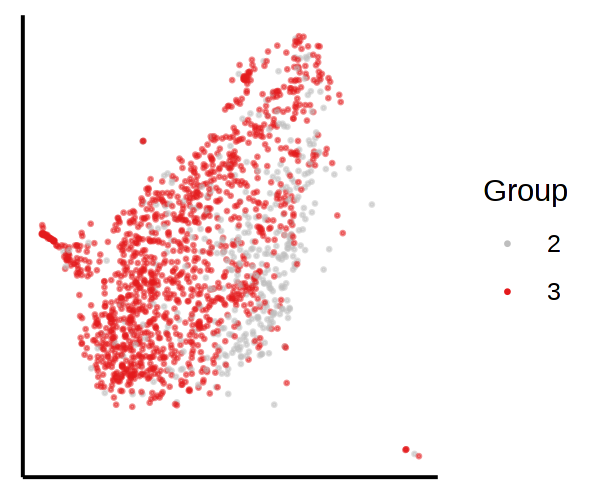

In [243]:
options(repr.plot.width = 3, repr.plot.height = 2.5, repr.plot.res = 200)

con_sample$plotEmbedding(
    alpha=0.5,
    size=0.2, 
    groups = de_annot %>% {setNames(.$clone_opt, .$cell)},
    plot.na = F,
    show.legend = T,
    mark.groups = F,
    palette = c('gray', pal[1:3]),
    plot.theme = theme_classic(),
#     title = 'genetic clone'
) 

Warning message:
“ggrepel: 75 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


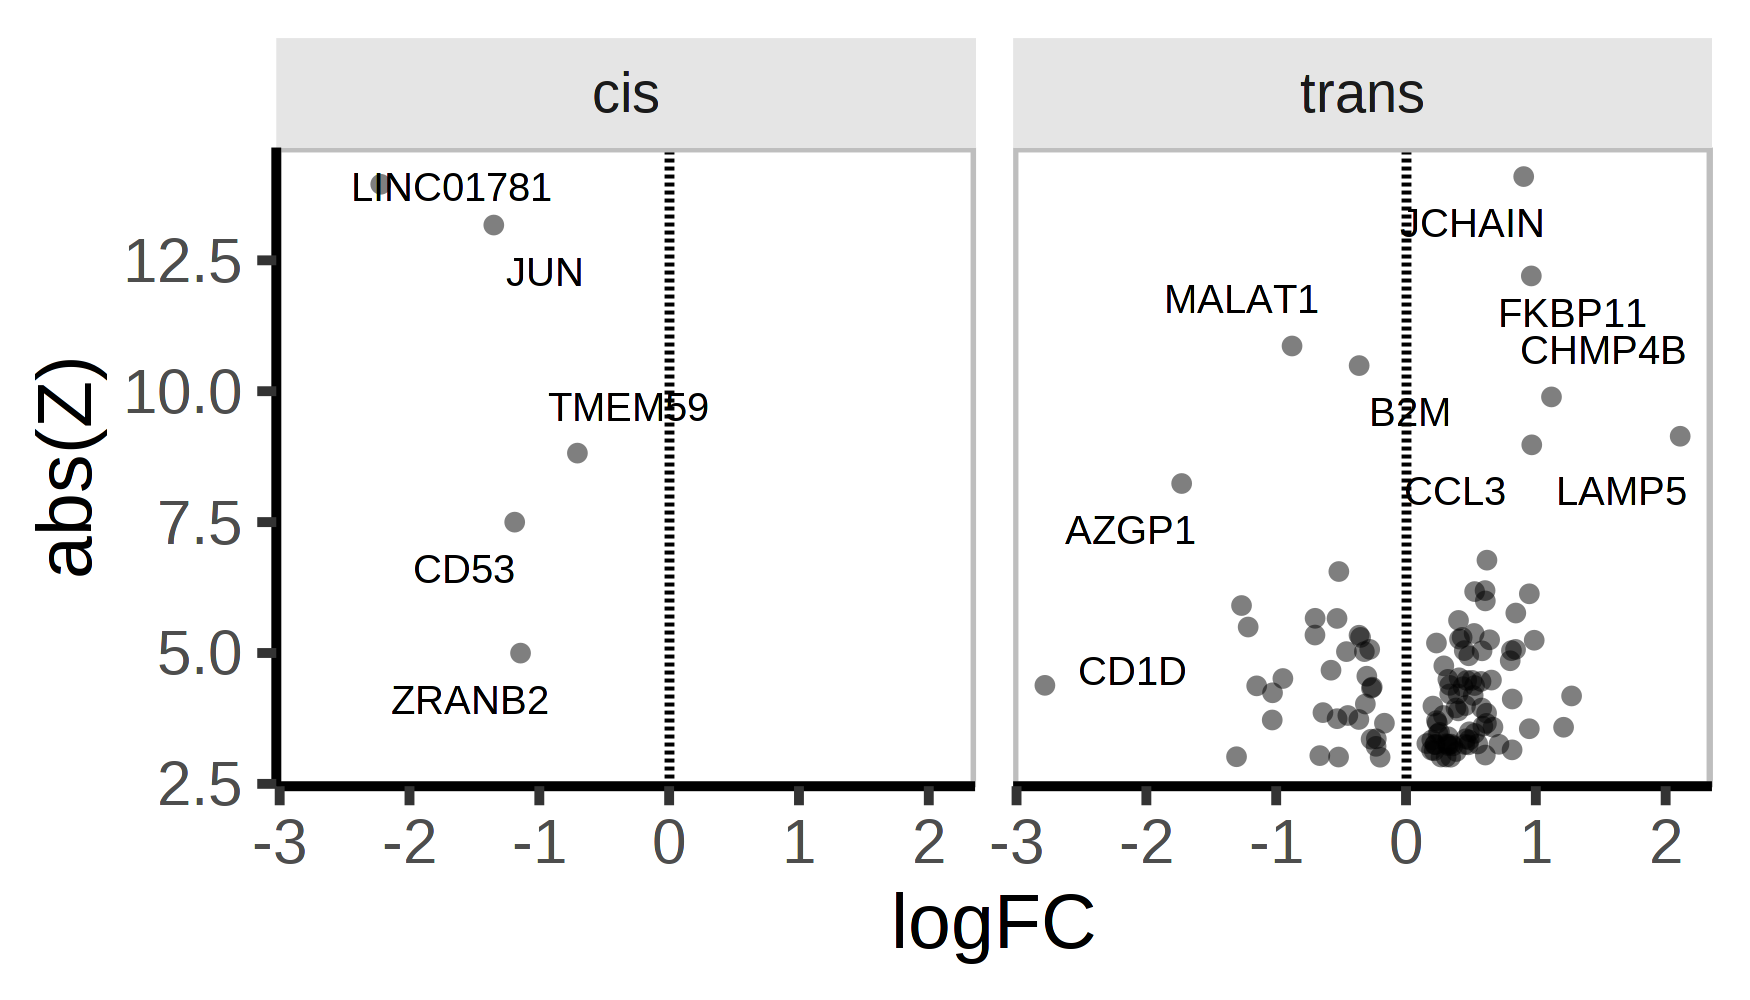

In [244]:
options(repr.plot.width = 3.5, repr.plot.height = 2, repr.plot.res = 500)

seg_start = 52085411
seg_end = 144887191

DE = con_sample$diffgenes$counts$customClustering[[1]] %>%
    tibble::rownames_to_column('gene') %>%
    inner_join(gtf_transcript, by = 'gene') %>%
    left_join(fold_changes, by = 'gene') %>%
    mutate(
        loc = ifelse(CHROM == 1 & gene_start < seg_end & gene_end > seg_start, 'cis', 'trans')
    )

ggplot(
    DE,
    aes(x = logFC, y = abs(Z))
) +
geom_point(size = 1, alpha = 0.5, pch = 16) +
theme_classic() +
scale_color_manual(values = c('gray', 'red')) +
facet_wrap(~loc) +
geom_text_repel(aes(label = gene), size = 2) +
geom_vline(xintercept = 0, linetype = 'dashed') +
theme(
    panel.border = element_rect(size = 0.5, color = 'gray', fill = NA),
    strip.background = element_rect(fill = 'gray90', size = 0),
    strip.text = element_text(size = 8)
)

In [245]:
DE %>% count(loc)

loc   n  
1 cis     5
2 trans 117

In [223]:
expressed_genes = rownames(count_mat[[sample]])[rowSums(count_mat[[sample]][,de_annot$cell] > 0) >= 5]

gsea_out = bulk.gsea(
    values = fold_changes %>% 
        filter(gene %in% expressed_genes) %>%
        filter(!is.infinite(logFC)) %>% 
        {setNames(.$logFC, .$gene)},
    set.list = h_gene_sets,
    mc.cores = 10
) %>%
tibble::rownames_to_column('gene.set') 

In [224]:
gsea_out %>%
filter(q.val < 0.05 & sscore * edge > 0) %>%
arrange(q.val, -sscore)

gene.set                          p.val      q.val      sscore    edge     
1 E2F_TARGETS                       0.00009999 0.00000000 3.6373765 0.5622613
2 G2M_CHECKPOINT                    0.00009999 0.00000000 3.1848506 0.6834630
3 MITOTIC_SPINDLE                   0.00009999 0.00000000 2.1671602 0.2551801
4 SPERMATOGENESIS                   0.00009999 0.00037000 1.4017102 1.1309220
5 EPITHELIAL_MESENCHYMAL_TRANSITION 0.00679932 0.02209231 1.0425442 0.3533144
6 MYOGENESIS                        0.01219878 0.04110667 0.9799496 0.9722242
7 ANDROGEN_RESPONSE                 0.01379862 0.04110667 0.9649671 0.1198294
8 ESTROGEN_RESPONSE_LATE            0.01659834 0.04543333 0.9414063 0.6428210

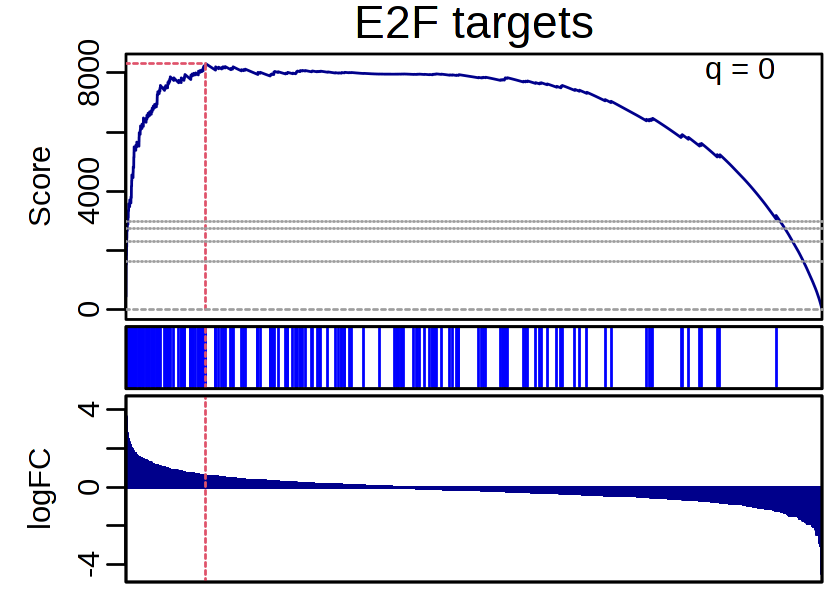

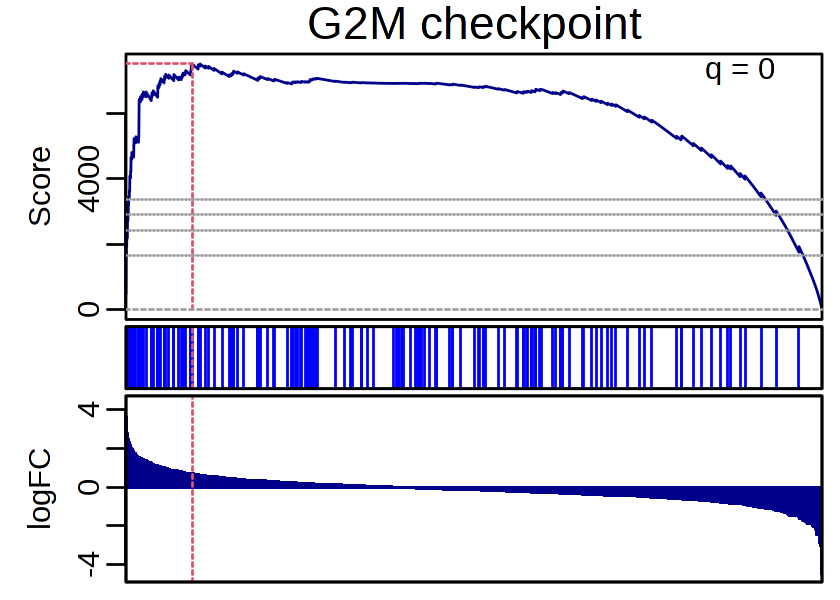

In [225]:
options(repr.plot.width = 4.2, repr.plot.height = 3, repr.plot.res = 200)

rename_dict = c('E2F_TARGETS' = expression('E2F targets'), 'G2M_CHECKPOINT' = expression('G2M checkpoint'))

for (gs in c('E2F_TARGETS', 'G2M_CHECKPOINT')) {

    gsea(
        fold_changes %>% 
            filter(gene %in% expressed_genes) %>%
            filter(!is.infinite(logFC)) %>%
            {setNames(.$logFC, .$gene)},
        h_gene_sets[[gs]],
        q.val = gsea_out %>% filter(gene.set == gs) %>% pull(q.val),
        main = rename_dict[gs]
    )
    
}

In [246]:
seg_start = 52085411
seg_end = 121518467
region_mb = seg_end - seg_start
genome_size = 

gtf_transcript %>% filter(gene %in% h_gene_sets[['G2M_CHECKPOINT']])  %>%
count(CHROM == 'chr1' & gene_start > 52085411 & gene_end < 121518467) 

binom.test(x = 4, n = 200, p = region_mb/genome_size)

CHROM == "chr1" & gene_start > 52085411 & gene_end < 121518467 n  
1 FALSE                                                          193

ERROR: Error in binom.test(x = 4, n = 200, p = region_mb/genome_size): object 'genome_size' not found


#### **Clone 2 vs 4**

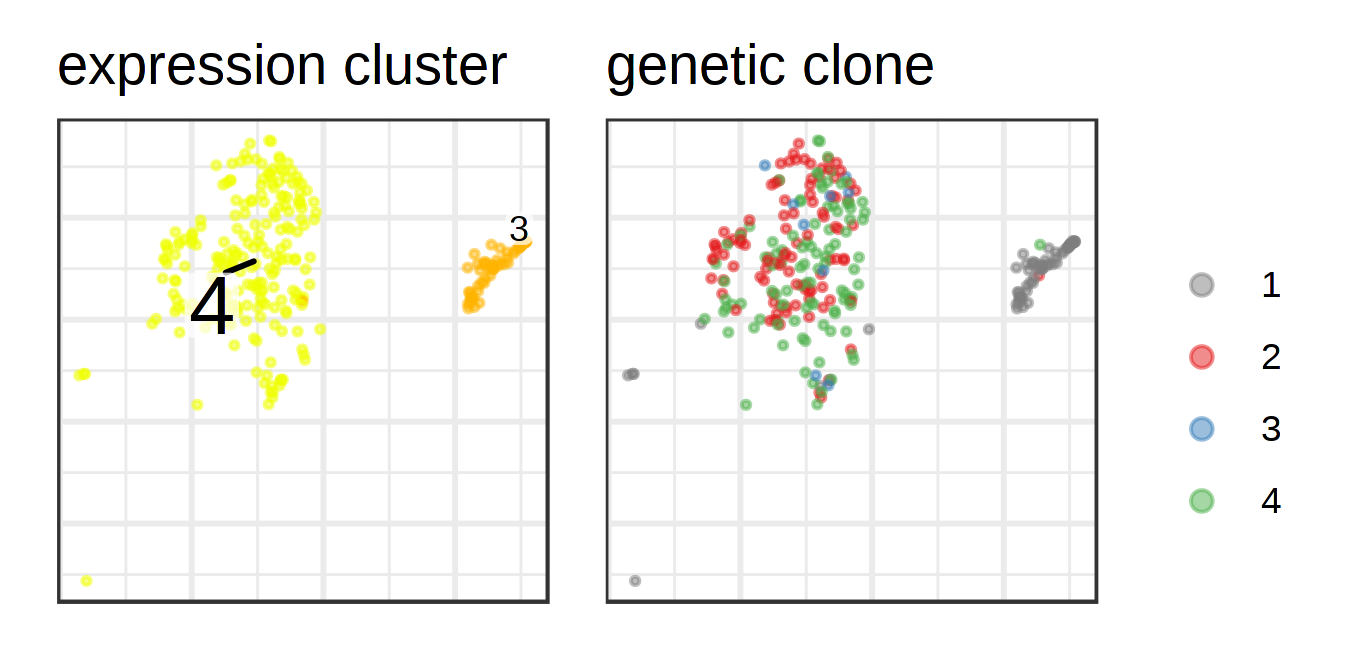

In [370]:
options(repr.plot.width = 4.5, repr.plot.height = 2.2, repr.plot.res = 300)

sample = '27522_Relapse_2'

# expression clusters
con_sample = con$samples[[sample]]

con_clusters = con_sample$clusters$PCA$multilevel
con_clusters = con_clusters[names(con_clusters) %in% res$clone_post$cell]
con_clusters = con_clusters[con_clusters %in% c(3,4)]

clone_annot = res$clone_post %>%
    mutate(cluster = con_clusters[cell]) %>%
    filter(!is.na(cluster))

p1 = con_sample$plotEmbedding(
        alpha=0.5,
        size=0.5, 
        groups = con_clusters,
        show.legend = F,
        plot.na = F,
        plot.theme = theme_bw(),
        title = 'expression cluster'
    ) +
    guides(color = guide_legend(title = 'cluster'))

p2 = con_sample$plotEmbedding(
    alpha=0.5,
    size=0.5, 
    groups = clone_annot %>% {setNames(.$clone_opt, .$cell)},
    plot.na = F,
    show.legend = T,
    mark.groups = F,
    palette = c('gray50', pal[1:3]),
    plot.theme = theme_bw(),
    title = 'genetic clone'
) +
guides(color = guide_legend(title = '', override.aes = list(size = 2))) 

p1 | p2

Warning message in con_sample$getDifferentialGenes(groups = de_annot %>% {:
“cluster vector doesn't specify groups for all of the cells, dropping missing cells from comparison”
10197



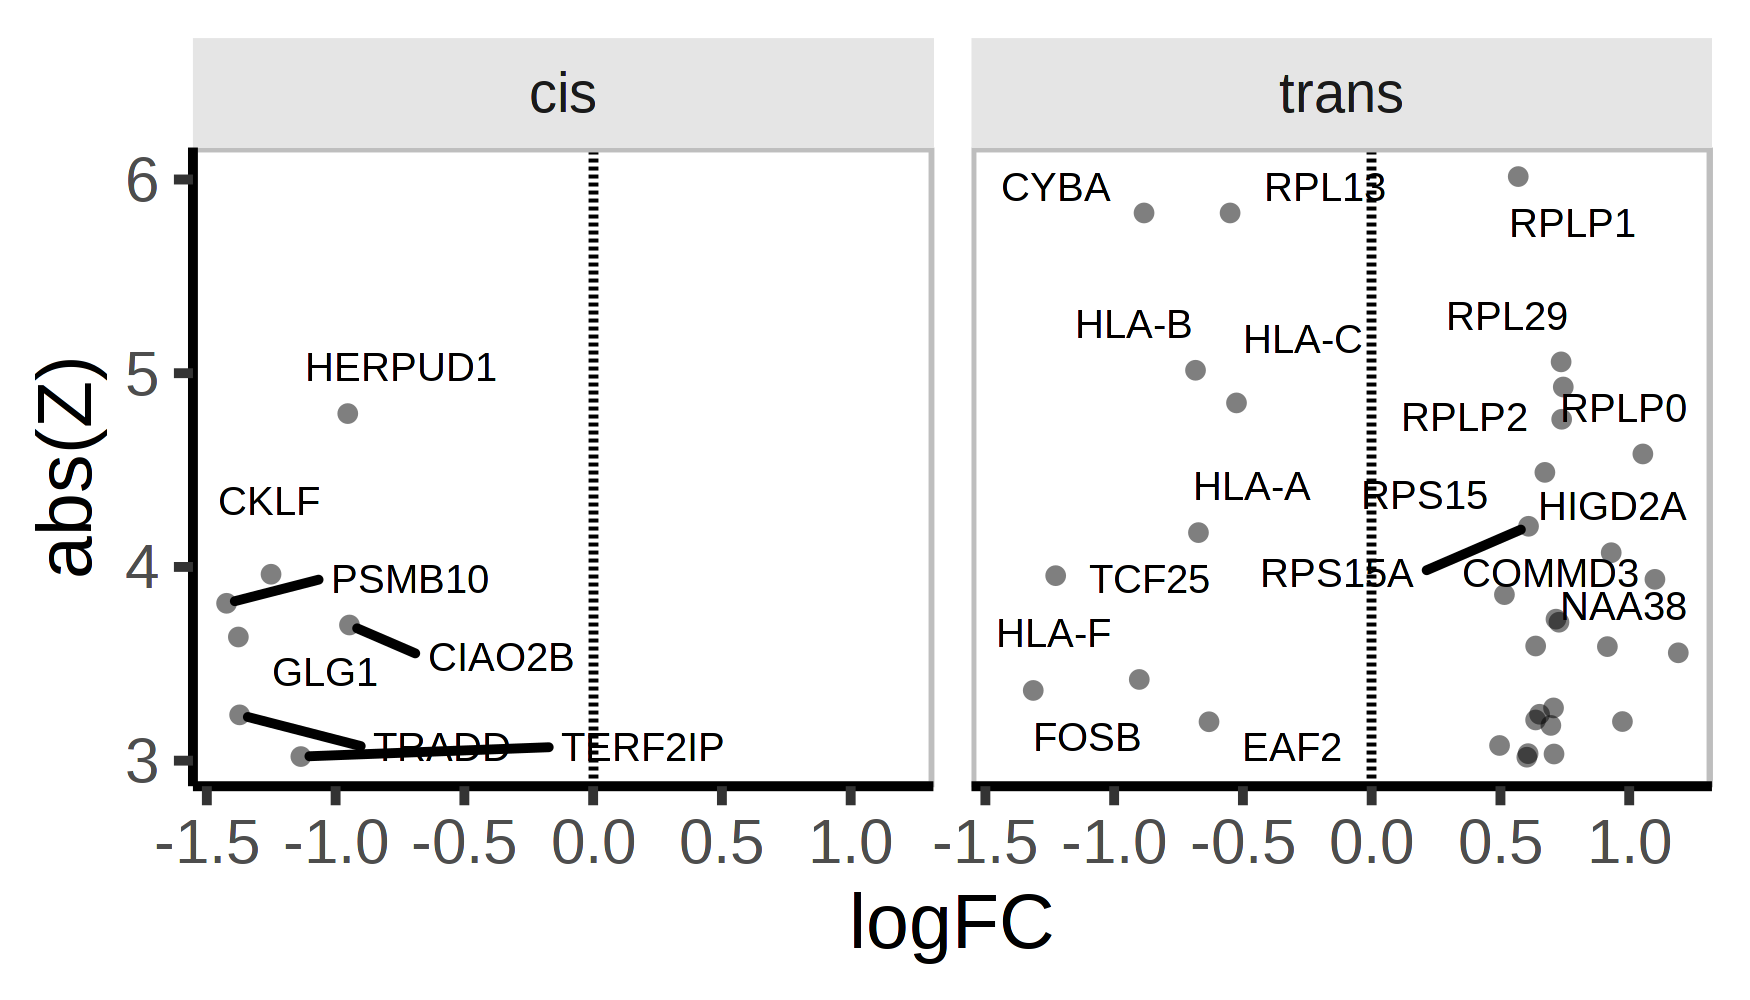

In [373]:
options(repr.plot.width = 3.5, repr.plot.height = 2, repr.plot.res = 500)

# DE
de_annot = clone_annot %>% filter(clone_opt %in% c(2,4))

con_sample = con$samples[['27522_Relapse_2']]

con_sample$getDifferentialGenes(
    groups = de_annot %>% {setNames(.$clone_opt, .$cell)}
)

fold_changes = make_psbulk(
        count_mat[[sample]],
        de_annot %>% mutate(cell_type = factor(clone_opt, c(4,2)))
    )$exp_mat %>%
    data.frame() %>%
    setNames(c('lambda_x', 'lambda_y')) %>%
    tibble::rownames_to_column('gene') %>%
    mutate(logFC = log2(lambda_x/lambda_y)) %>%
    filter(!is.na(logFC) & !is.infinite(logFC))

# visualize
seg_start = 54009095
seg_end = 85723222

DE = con_sample$diffgenes$counts$customClustering[[1]] %>%
    tibble::rownames_to_column('gene') %>%
    inner_join(gtf_transcript, by = 'gene') %>%
    left_join(fold_changes, by = 'gene') %>%
    mutate(loc = ifelse(CHROM == 16 & gene_start < seg_end & gene_end > seg_start, 'cis', 'trans'))

ggplot(
    DE,
    aes(x = logFC, y = abs(Z))
) +
geom_point(size = 1, alpha = 0.5, pch = 16) +
theme_classic() +
scale_color_manual(values = c('gray', 'red')) +
facet_wrap(~loc) +
geom_text_repel(aes(label = gene), size = 2) +
geom_vline(xintercept = 0, linetype = 'dashed') +
theme(
    panel.border = element_rect(size = 0.5, color = 'gray', fill = NA),
    strip.background = element_rect(fill = 'gray90', size = 0),
    strip.text = element_text(size = 8)
)

In [240]:
DE %>% count(loc)

loc   n 
1 cis    7
2 trans 33

In [228]:
expressed_genes = rownames(count_mat[[sample]])[rowSums(count_mat[[sample]][,de_annot$cell] > 0) >= 5]

gsea_out = bulk.gsea(
    values = fold_changes %>% 
        filter(gene %in% expressed_genes) %>%
        filter(!is.infinite(logFC)) %>% 
        {setNames(.$logFC, .$gene)},
    set.list = h_gene_sets,
    n.rand = 1e4,
    mc.cores = 10
) %>%
tibble::rownames_to_column('gene.set') 

In [374]:
expressed_genes = rownames(count_mat[[sample]])[rowSums(count_mat[[sample]][,de_annot$cell] > 0) >= 5]

fold_changes %>% 
        filter(gene %in% expressed_genes) %>%
        filter(!is.infinite(logFC)) %>% dim

[1] 11545     4

In [229]:
gsea_out %>%
filter(q.val < 0.05 & sscore * edge > 0) %>%
arrange(q.val, -sscore)

gene.set                  p.val      q.val      sscore    edge      
1 INTERFERON_GAMMA_RESPONSE 0.00109989 0.01646667 -1.210271 -0.1511966

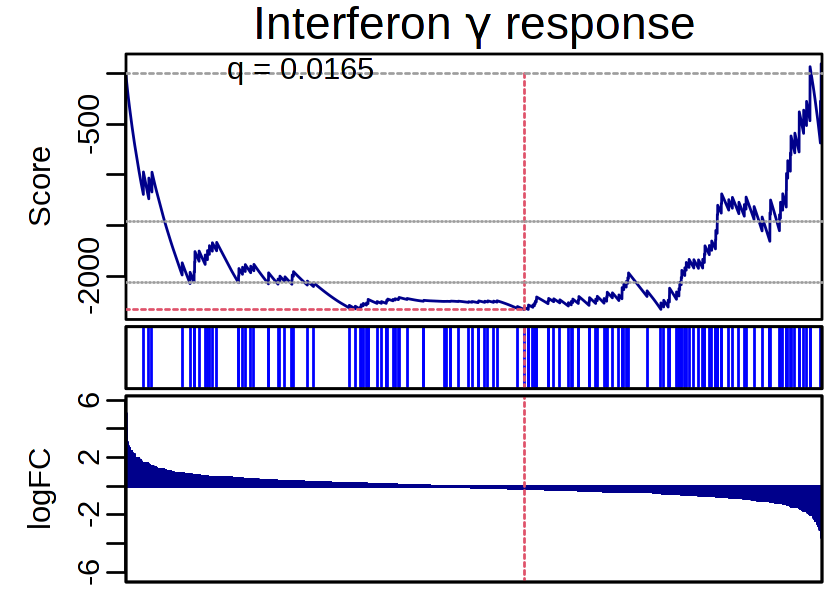

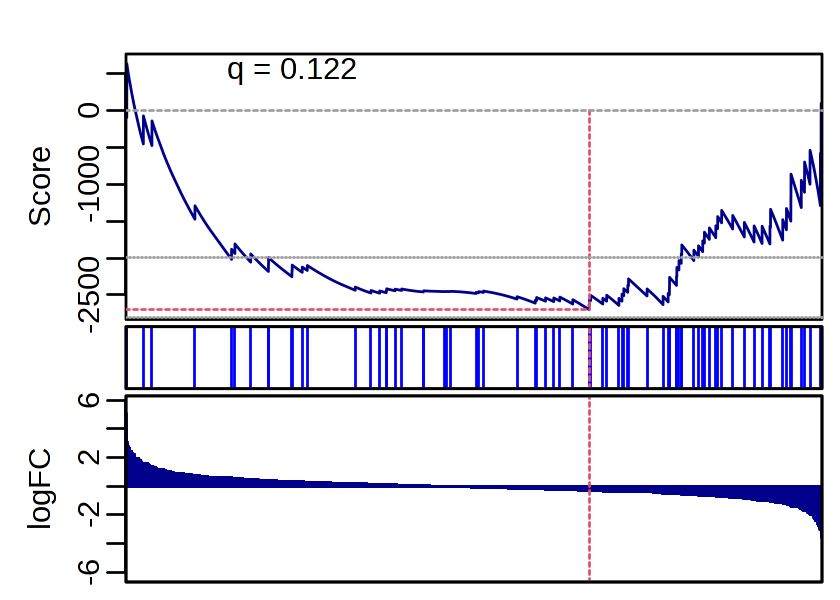

In [230]:
options(repr.plot.width = 4.2, repr.plot.height = 3, repr.plot.res = 200)

rename_dict = c('INTERFERON_GAMMA_RESPONSE' = expression(paste('Interferon ', gamma, ' response')))

for (gs in c('INTERFERON_GAMMA_RESPONSE', 'INTERFERON_ALPHA_RESPONSE')) {

    gsea(
        values = fold_changes %>% 
            filter(gene %in% expressed_genes) %>%
            filter(!is.infinite(logFC)) %>%
            {setNames(.$logFC, .$gene)},
        h_gene_sets[[gs]],
        ypos = 'top',
        q.val = gsea_out %>% filter(gene.set == gs) %>% pull(q.val),
        main = rename_dict[gs]
    )
    
}

In [1581]:
DE %>% 
filter(loc == 'cis') %>%
filter(gene %in% h_gene_sets[['INTERFERON_GAMMA_RESPONSE']])

gene   Z        M         highest fe        Gene   Specificity Precision
1 PSMB10 4.191319 0.5441654 TRUE    0.7722772 PSMB10 0.5819672   0.6046512
  ExpressionFraction gene_start gene_end CHROM region                    
1 0.7722772          67934507   67936850 chr16 chrchr16:67934507-67936850
  gene_length lambda_x    lambda_y     logFC     loc
1 2343        4.77268e-05 0.0001339438 -1.488756 cis

In [1584]:
gtf_transcript %>%
filter(gene %in% h_gene_sets[['INTERFERON_GAMMA_RESPONSE']]) %>%
count(CHROM == 'chr16' & gene_start > 54009095 & gene_end < 85723222)

CHROM == "chr16" & gene_start > 54009095 & gene_end < 85723222 n  
1 FALSE                                                          196
2  TRUE                                                            4

In [1585]:
region_mb = (85723222 - 54009095)
prop.test(x = 4, n = 200, p = region_mb/genome_size)

Warning message in prop.test(x = 4, n = 200, p = region_mb/genome_size):
“Chi-squared approximation may be incorrect”



	1-sample proportions test with continuity correction

data:  4 out of 200, null probability region_mb/genome_size
X-squared = 1.0288, df = 1, p-value = 0.3104
alternative hypothesis: true p is not equal to 0.01026922
95 percent confidence interval:
 0.006426013 0.053757461
sample estimates:
   p 
0.02 


## tSNE panel

Warning message:
“Removed 65 rows containing missing values (geom_point).”
Warning message:
“Removed 16 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


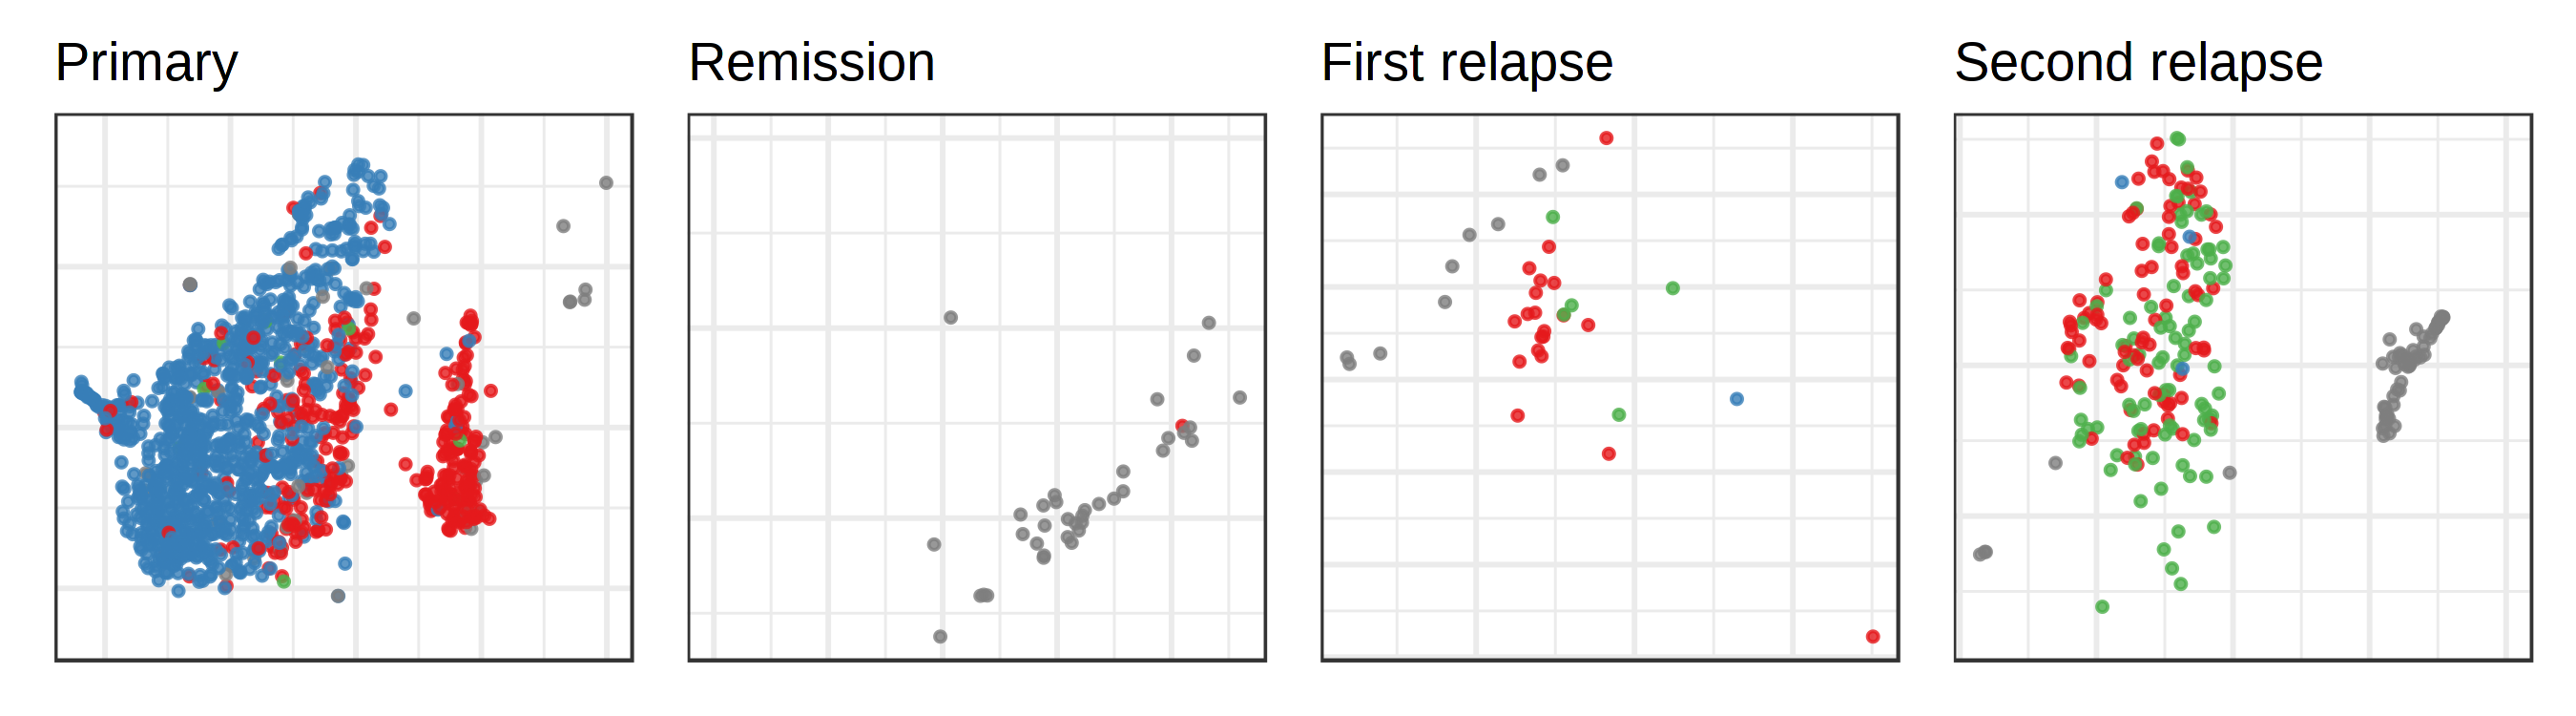

In [237]:
options(repr.plot.width = 9, repr.plot.height = 2.5, repr.plot.res = 300)

size = 0.8
alpha = 0.8
p_min = 0.9

sample = '27522_Primary'

p1 = con$samples[[sample]]$plotEmbedding(
    alpha=alpha,
    size=size, 
    palette = c('gray50', pal[1:3]),
    groups = res$clone_post %>% filter(p_opt > p_min) %>% {setNames(.$clone_opt, .$cell)},
    show.legend = F,
    mark.groups = F,
    plot.na = F,
    plot.theme = theme_bw(),
    title.size = 3,
    title = 'Primary'
) +
# theme_bw() +
xlim(NA, 10) +
ylim(-13, 18) +
guides(colour = guide_legend(override.aes = list(size = 2), title = 'clone'))


sample = '27522_Remission'

p2 = con$samples[[sample]]$plotEmbedding(
    alpha=alpha,
    size=size, 
    palette = c('gray50', pal[1:3]),
    groups = res$clone_post %>% filter(p_opt > p_min) %>% {setNames(.$clone_opt, .$cell)},
    show.legend = F,
    mark.groups = F,
    plot.na = F,
    plot.theme = theme_bw(),
    title.size = 3,
    title = 'Remission'
) +
# theme_bw() +
ylim(NA, -25) +
xlim(-16, NA) +
guides(colour = guide_legend(override.aes = list(size = 2), title = 'clone'))

sample = '27522_Relapse_1'

p3 = con$samples[[sample]]$plotEmbedding(
    alpha=alpha,
    size=size, 
    palette = c('gray50', pal[1:3]),
    groups = res$clone_post %>% filter(p_opt > p_min) %>% {setNames(.$clone_opt, .$cell)},
    show.legend = F,
    mark.groups = F,
    plot.na = F,
    plot.theme = theme_bw(),
    title.size = 3,
    title = 'First relapse'
) +
# xlim(27, NA) +
# ylim(-10, NA) +
guides(colour = guide_legend(override.aes = list(size = 2), title = 'clone'))

sample = '27522_Relapse_2'

p4 = con$samples[[sample]]$plotEmbedding(
    alpha=alpha,
    size=size, 
    palette = c('gray50', pal[1:3]),
    groups = res$clone_post %>% filter(p_opt > p_min) %>% {setNames(.$clone_opt, .$cell)},
    show.legend = F,
    mark.groups = F,
    plot.na = F,
    plot.theme = theme_bw(),
    title.size = 3,
    title = 'Second relapse'
) +
# theme_bw() +
xlim(NA, 20) +
ylim(33, NA) +
guides(colour = guide_legend(override.aes = list(size = 2), title = 'clone'))

p1 | p2 | p3 | p4

### Clonal dynamics

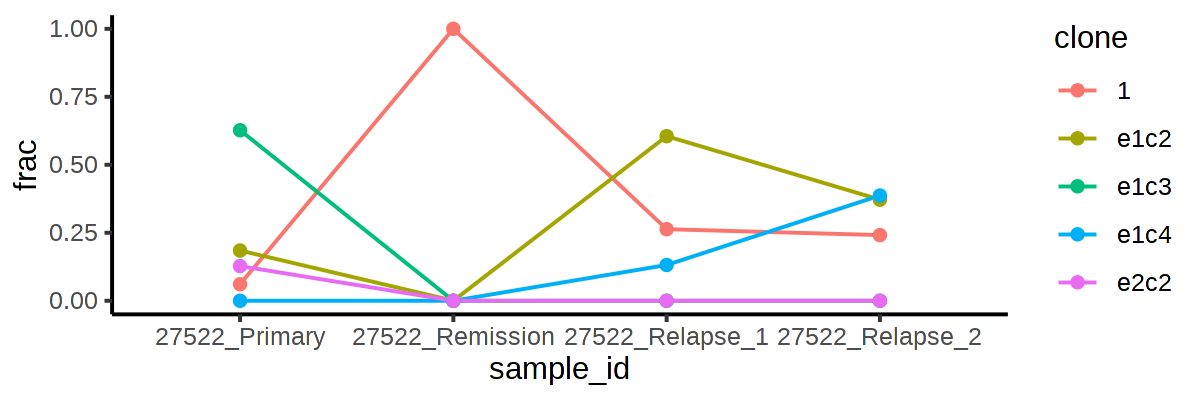

In [138]:
options(repr.plot.width = 6, repr.plot.height = 2, repr.plot.res = 200)

con_clusters = con_sample$clusters$PCA$multilevel
con_clusters = con_clusters[names(con_clusters) %in% res$clone_post$cell]
con_clusters[con_clusters %in% c(2,3,8)] = 1
con_clusters[con_clusters %in% c(12)] = 2
con_clusters = con_clusters[con_clusters %in% c(1,2)]

frac_table = res$clone_post %>%
    mutate(clone = factor(clone_opt)) %>%
    mutate(cluster = con_clusters[cell]) %>%
    inner_join(bind_rows(cell_annot[samples]), by = 'cell') %>%
    mutate(sample_id = factor(sample_id, samples)) %>%
    mutate(clone = ifelse(sample_id == '27522_Primary' & clone != 1, paste0('e', cluster, 'c', clone), clone)) %>%
    mutate(clone = ifelse(sample_id != '27522_Primary' & clone != 1, paste0('e1c', clone), clone)) %>%
    filter(!(sample_id == '27522_Primary' & is.na(cluster))) %>%
    count(sample_id, clone) %>%
    group_by(sample_id) %>%
    mutate(frac = n/sum(n)) %>%
    filter(frac > 0.05) %>%
    mutate(frac = n/sum(n)) %>%
    ungroup() %>%
    tidyr::complete(sample_id, clone, fill = list('n' = 0, 'frac' = 0)) 

frac_table %>%
ggplot(
    aes(x = sample_id, y = frac, color = clone, group = clone)
) +
theme_classic() +
geom_line() +
geom_point()

In [148]:
timepoints = setNames(c(0, 1.1, 2.85, 3.15), str_remove(samples, '27522_'))      

frac_table_wide = frac_table %>%
    reshape2::dcast(clone ~ sample_id, value.var = 'frac') %>%
    tibble::column_to_rownames('clone') %>%
    as.matrix

frac_trunc = colSums(frac_table_wide[2:5,]) + 1e-6
frac_c2 = colSums(frac_table_wide[2:4,])
frac_table_wide['e1c3',] = frac_table_wide['e1c3',] + 1e-6

frac_table_wide[2,] = frac_c2
frac_table_wide = frac_table_wide %>% rbind(frac_trunc)

parents = c(0,6,2,2,6,0)

[1] "WARNING: there were not 3 background gradient colors set - falling back to defaults"


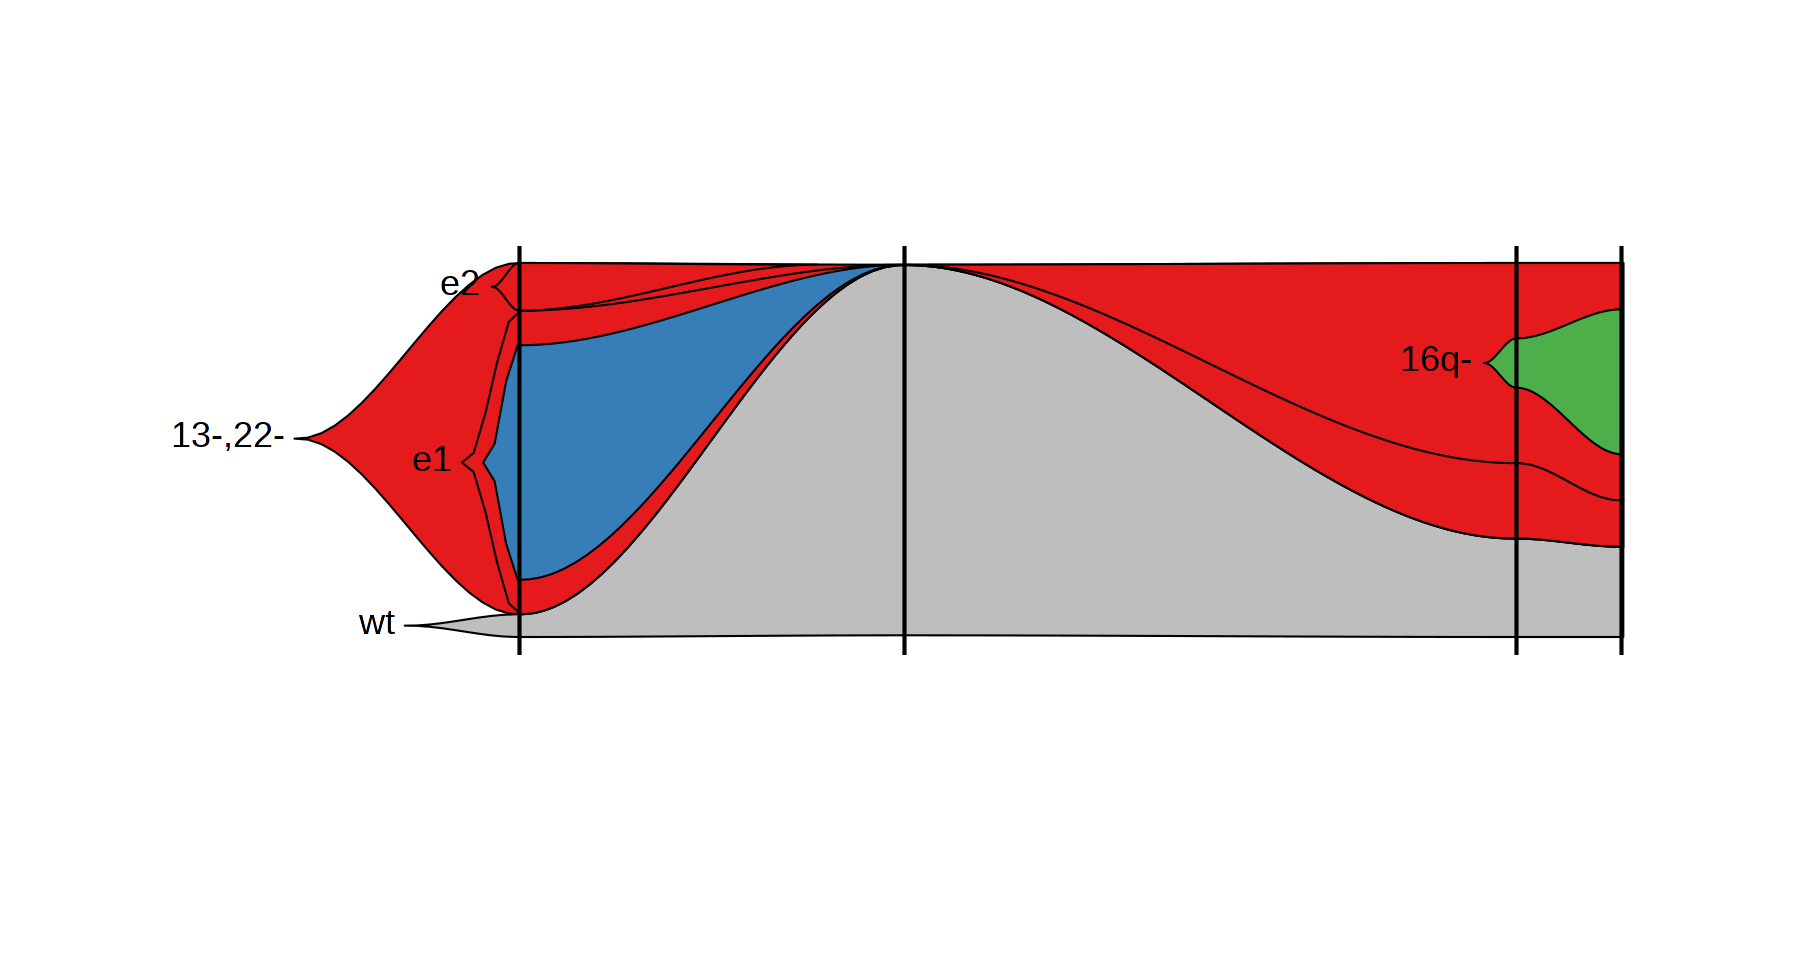

In [150]:
options(repr.plot.width = 6, repr.plot.height = 3.2, repr.plot.res = 300)

pal = RColorBrewer::brewer.pal(n = 8, 'Set1')

frac_table_wide[,'27522_Remission'] = c(0.99, 0.001, 0.0001, 0, 0, 0.001)

fish = fishplot::createFishObject(
    frac_table_wide * 99, parents,
    timepoints = timepoints, 
#     fix.missing.clones=TRUE, 
    col = c('gray', pal[1], pal[2:3], pal[1], pal[1]),
    clone.annots = c('wt', 'e1', '', '16q-', 'e2', '13-,22-')
)

#calculate the layout of the drawing
fish = fishplot::layoutClones(fish)

fishplot::fishPlot(
#     ramp.angle = 1,
    fish,
    shape="spline",
    vlines = timepoints,
#     vlab = names(timepoints),
    cex.vlab = 0.4,
    bg.col = 'white',
    bg.type = 's',
#     border = 0.9,
    col.border = 'black',
    col.vline = 'black'
)

In [ ]:
timepoints = setNames(c(0, 1.1, 2.85, 3.15), str_remove(samples, '27522_'))      

frac_table_wide = frac_table %>%
    reshape2::dcast(clone ~ sample_id, value.var = 'frac') %>%
    tibble::column_to_rownames('clone') %>%
    as.matrix

frac_table_wide[4,'27522_Primary'] = 0
frac_table_wide[3,'27522_Relapse_2'] = 0
frac_table_wide[3,'27522_Relapse_1'] = 0

frac_table_wide[2,] = colSums(frac_table_wide[2:4,])

parents = c(0,0,2,2)

[1] "WARNING: there were not 3 background gradient colors set - falling back to defaults"


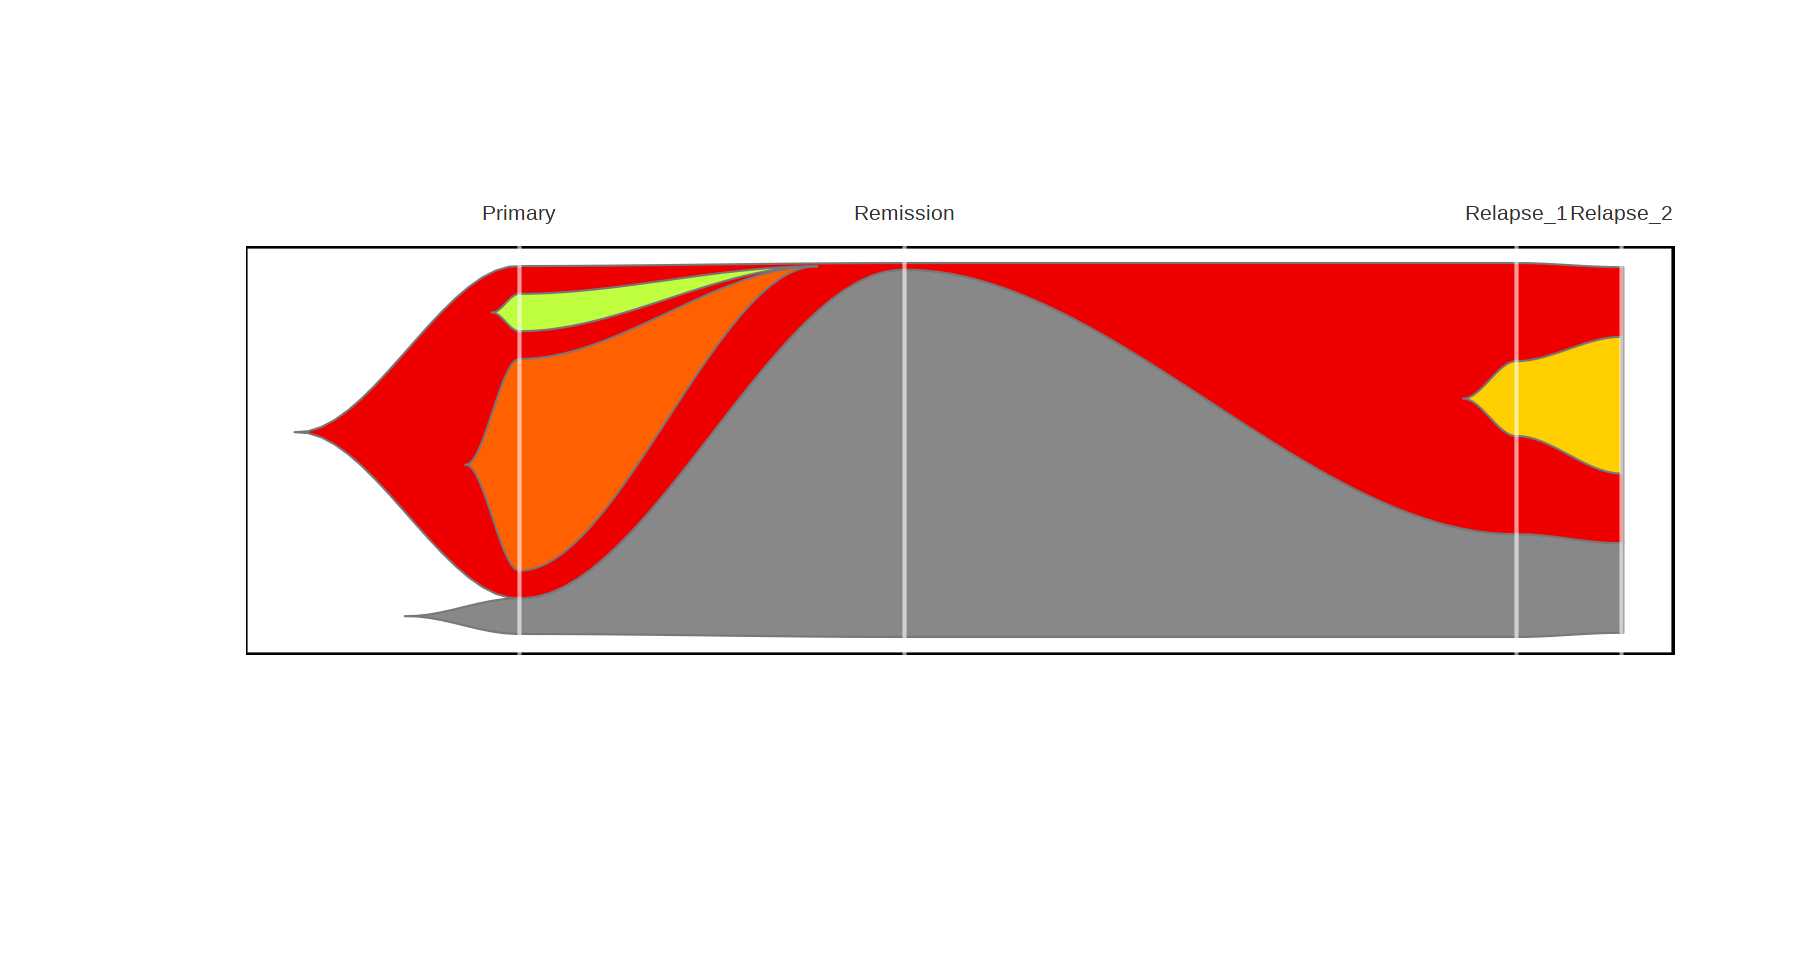

In [1304]:
options(repr.plot.width = 6, repr.plot.height = 3.2, repr.plot.res = 300)

pal = RColorBrewer::brewer.pal(n = 8, 'Set1')

fish = fishplot::createFishObject(
    frac_table_wide * 99, parents,
    timepoints = timepoints, fix.missing.clones=TRUE, 
    col = c('gray', pal[1:3]),
    clone.annots = c('wt', '13-,22-', '1-', '16q-')
)

#calculate the layout of the drawing
fish = fishplot::layoutClones(fish)

fishplot::fishPlot(
    fish,
    shape="spline",
    vlines = timepoints, 
    vlab = names(timepoints),
    cex.vlab = 0.4,
    bg.col = 'white',
    bg.type = 'solid'
)